In [11]:
# Drone Localization RL Agent with Similarity-Based Rewards
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import cv2
import json
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms as transforms
import torchvision.models as models
from collections import deque
import pickle

class DroneLocalizationEnvironment:
    """
    RL Environment for drone crop localization using similarity-based rewards
    """
    
    def __init__(self, tif_image_path: str = None, crops_metadata_path: str = None, grid_size: int = 20):
        # Auto-detect file paths if not provided
        if tif_image_path is None:
            tif_image_path = self._find_tif_file()
        if crops_metadata_path is None:
            crops_metadata_path = self._find_metadata_file()
            
        self.tif_image_path = tif_image_path
        self.crops_metadata_path = crops_metadata_path
        self.grid_size = grid_size
        
        # Load data
        self.tif_image = None
        self.crops_data = []
        self.current_crop = None
        self.current_metadata = None
        
        # Feature extractor for similarity
        self.feature_extractor = self._initialize_feature_extractor()
        
        # Normalization
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        print(f"🎯 Initializing Drone Localization Environment")
        print(f"   TIF file: {self.tif_image_path}")
        print(f"   Metadata: {self.crops_metadata_path}")
        print(f"   Grid size: {grid_size}×{grid_size} = {grid_size**2} possible locations")
        
        self.load_data()
    
    def _initialize_feature_extractor(self):
        """Initialize pretrained feature extractor for similarity"""
        # Use ResNet18 as feature extractor
        resnet = models.resnet18(pretrained=True)
        # Remove final classification layer
        feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        feature_extractor.eval()
        
        # Freeze parameters
        for param in feature_extractor.parameters():
            param.requires_grad = False
        
        return feature_extractor
    
    def _find_tif_file(self) -> str:
        """Auto-detect TIF file in current directory"""
        possible_names = [
            "sentinel2_ukraine_10km.TIF",
            "sentinel2_ukraine_10km.tif", 
            "sentinel2_ukraine_10km.TIFF",
            "sentinel2_ukraine_10km.tiff",
            "sentinel2_ukraine_10km"
        ]
        
        for name in possible_names:
            if Path(name).exists():
                print(f"   ✅ Found TIF file: {name}")
                return name
        
        # If not found, look for any TIF file
        for ext in [".TIF", ".tif", ".TIFF", ".tiff"]:
            tif_files = list(Path(".").glob(f"*{ext}"))
            if tif_files:
                print(f"   ✅ Found TIF file: {tif_files[0]}")
                return str(tif_files[0])
        
        raise FileNotFoundError("❌ No TIF file found! Please check your directory.")
    
    def _find_metadata_file(self) -> str:
        """Auto-detect metadata file in crops directory"""
        possible_paths = [
            "realistic_drone_crops/altitude_realistic_drone_metadata.json",
            "realistic_drone_crops/realistic_drone_metadata.json", 
            "realistic_drone_crops/metadata.json"
        ]
        
        for path in possible_paths:
            if Path(path).exists():
                print(f"   ✅ Found metadata: {path}")
                return path
        
        # Look for any JSON file in crops directory
        crops_dir = Path("realistic_drone_crops")
        if crops_dir.exists():
            json_files = list(crops_dir.glob("*.json"))
            if json_files:
                print(f"   ✅ Found metadata: {json_files[0]}")
                return str(json_files[0])
        
        raise FileNotFoundError("❌ No metadata file found in realistic_drone_crops/!")
    
    
    def load_data(self):
        """Load TIF image and crops metadata"""
        try:
            # Load TIF image
            self.tif_image = cv2.imread(self.tif_image_path)
            if self.tif_image is not None:
                self.tif_image = cv2.cvtColor(self.tif_image, cv2.COLOR_BGR2RGB)
                print(f"   ✅ Loaded TIF: {self.tif_image.shape}")
            else:
                print(f"   ❌ Could not load TIF image from: {self.tif_image_path}")
                return
            
            # Load crops metadata
            if Path(self.crops_metadata_path).exists():
                with open(self.crops_metadata_path, 'r') as f:
                    metadata = json.load(f)
                    self.crops_data = metadata['crops']
                print(f"   ✅ Loaded {len(self.crops_data)} crop metadata entries")
                
                # Verify crop files exist (specifically JPG files)
                crops_dir = Path("realistic_drone_crops")
                existing_crops = []
                missing_crops = []
                
                for crop in self.crops_data:
                    crop_file = crops_dir / crop['filename']
                    if crop_file.exists() and crop_file.suffix.lower() in ['.jpg', '.jpeg']:
                        # Test if the JPG file can actually be loaded
                        test_img = cv2.imread(str(crop_file))
                        if test_img is not None:
                            existing_crops.append(crop)
                        else:
                            print(f"   ⚠️ JPG file corrupted: {crop['filename']}")
                            missing_crops.append(crop['filename'])
                    else:
                        missing_crops.append(crop['filename'])
                
                # Update crops_data to only include loadable crops
                self.crops_data = existing_crops
                
                print(f"   ✅ Found {len(existing_crops)} valid JPG crop files")
                if missing_crops:
                    print(f"   ⚠️ Missing/corrupted JPG files: {len(missing_crops)}")
                    if len(missing_crops) <= 5:  # Show first few missing files
                        for missing in missing_crops[:5]:
                            print(f"      - {missing}")
                
                if len(existing_crops) == 0:
                    raise RuntimeError("❌ No valid JPG crop files found in realistic_drone_crops/!")
                    
                # Show sample of available crops
                print(f"   📸 Sample crop files:")
                for i, crop in enumerate(existing_crops[:3]):
                    print(f"      - {crop['filename']} (altitude: {crop.get('altitude_meters', 'N/A')}m)")
                    
            else:
                print(f"   ❌ Metadata file not found: {self.crops_metadata_path}")
            
        except Exception as e:
            print(f"   ❌ Error loading data: {e}")
            raise
    
    def reset(self) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """Reset environment with a random crop"""
        if not self.crops_data:
            raise RuntimeError("❌ No crops data loaded! Please check your realistic_drone_crops directory.")
        
        # Select random crop
        crop_metadata = random.choice(self.crops_data)
        self.current_metadata = crop_metadata
        
        # Load crop image (JPG format)
        crop_path = Path("realistic_drone_crops") / crop_metadata['filename']
        
        # Ensure the file is a JPG and exists
        if not crop_path.exists():
            print(f"⚠️ Crop JPG file not found: {crop_path}")
            return self.reset()  # Try another crop
            
        if crop_path.suffix.lower() not in ['.jpg', '.jpeg']:
            print(f"⚠️ Expected JPG file but got: {crop_path}")
            return self.reset()  # Try another crop
        
        # Load the JPG image
        crop_image = cv2.imread(str(crop_path))
        if crop_image is not None:
            self.current_crop = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)
            
            # Validate image dimensions
            if self.current_crop.shape[0] < 32 or self.current_crop.shape[1] < 32:
                print(f"⚠️ Crop image too small: {self.current_crop.shape}")
                return self.reset()  # Try another crop
        else:
            print(f"⚠️ Could not read JPG file: {crop_path}")
            return self.reset()  # Try another crop
        
        # Prepare state
        state = {
            'tif_image': self.tif_image,
            'crop_image': self.current_crop,
            'metadata': self.current_metadata
        }
        
        return self.tif_image, self.current_crop, state
    
    def extract_area_at_grid(self, grid_x: int, grid_y: int, crop_size: int = 256) -> np.ndarray:
        """Extract area from TIF at grid coordinates"""
        h, w = self.tif_image.shape[:2]
        
        # Convert grid coordinates to pixel coordinates
        pixel_x = int((grid_x / self.grid_size) * w)
        pixel_y = int((grid_y / self.grid_size) * h)
        
        # Extract area
        half_size = crop_size // 2
        x1 = max(0, pixel_x - half_size)
        y1 = max(0, pixel_y - half_size)
        x2 = min(w, pixel_x + half_size)
        y2 = min(h, pixel_y + half_size)
        
        area = self.tif_image[y1:y2, x1:x2]
        
        # Resize to standard size
        if area.shape[0] > 0 and area.shape[1] > 0:
            area = cv2.resize(area, (crop_size, crop_size))
        else:
            area = np.zeros((crop_size, crop_size, 3), dtype=np.uint8)
        
        return area
    
    def calculate_similarity(self, crop1: np.ndarray, crop2: np.ndarray) -> float:
        """Calculate similarity between two crops using multiple methods"""
        
        # Method 1: Feature-based similarity
        feature_sim = self._feature_similarity(crop1, crop2)
        
        # Method 2: SSIM
        ssim_score = self._ssim_similarity(crop1, crop2)
        
        # Method 3: Histogram correlation
        hist_sim = self._histogram_similarity(crop1, crop2)
        
        # Combined similarity (weighted average)
        combined_similarity = 0.5 * feature_sim + 0.3 * ssim_score + 0.2 * hist_sim
        
        return float(combined_similarity)
    
    def _feature_similarity(self, crop1: np.ndarray, crop2: np.ndarray) -> float:
        """Feature-based similarity using pretrained CNN"""
        try:
            # Preprocess images
            img1_tensor = self.transform(crop1).unsqueeze(0)
            img2_tensor = self.transform(crop2).unsqueeze(0)
            
            with torch.no_grad():
                # Extract features
                features1 = self.feature_extractor(img1_tensor).flatten().numpy()
                features2 = self.feature_extractor(img2_tensor).flatten().numpy()
                
                # Cosine similarity
                similarity = cosine_similarity([features1], [features2])[0, 0]
                
                # Normalize to 0-1 range
                return (similarity + 1) / 2
        
        except Exception as e:
            print(f"Feature similarity error: {e}")
            return 0.0
    
    def _ssim_similarity(self, crop1: np.ndarray, crop2: np.ndarray) -> float:
        """Structural similarity index"""
        try:
            # Convert to grayscale for SSIM
            gray1 = cv2.cvtColor(crop1, cv2.COLOR_RGB2GRAY)
            gray2 = cv2.cvtColor(crop2, cv2.COLOR_RGB2GRAY)
            
            # Calculate SSIM
            similarity = ssim(gray1, gray2)
            
            # Normalize to 0-1 range
            return (similarity + 1) / 2
        
        except Exception as e:
            print(f"SSIM similarity error: {e}")
            return 0.0
    
    def _histogram_similarity(self, crop1: np.ndarray, crop2: np.ndarray) -> float:
        """Histogram-based similarity"""
        try:
            # Calculate histograms
            hist1 = cv2.calcHist([crop1], [0,1,2], None, [32,32,32], [0,256,0,256,0,256])
            hist2 = cv2.calcHist([crop2], [0,1,2], None, [32,32,32], [0,256,0,256,0,256])
            
            # Normalize histograms
            cv2.normalize(hist1, hist1)
            cv2.normalize(hist2, hist2)
            
            # Calculate correlation
            correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
            
            # Ensure positive range
            return max(0, correlation)
        
        except Exception as e:
            print(f"Histogram similarity error: {e}")
            return 0.0
    
    def calculate_reward(self, predicted_locations: List[Tuple[int, int]], 
                        predicted_probs: List[float]) -> float:
        """Calculate similarity-based reward for predictions"""
        
        total_reward = 0.0
        similarities = []
        
        for i, (grid_x, grid_y) in enumerate(predicted_locations):
            # Extract area at predicted location
            predicted_area = self.extract_area_at_grid(grid_x, grid_y)
            
            # Calculate similarity
            similarity = self.calculate_similarity(self.current_crop, predicted_area)
            similarities.append(similarity)
            
            # Reward = similarity * confidence (encourage confident good predictions)
            confidence = predicted_probs[i]
            prediction_reward = similarity * confidence
            
            # Ranking bonus (1st prediction gets more reward)
            ranking_bonus = [1.0, 0.8, 0.6][i]
            
            total_reward += prediction_reward * ranking_bonus
        
        # Diversity bonus (encourage exploring different areas)
        diversity_bonus = self._calculate_diversity_bonus(predicted_locations)
        
        final_reward = total_reward + diversity_bonus
        
        return final_reward, similarities
    
    def _calculate_diversity_bonus(self, locations: List[Tuple[int, int]]) -> float:
        """Bonus for predicting diverse locations (avoid clustering)"""
        if len(locations) < 2:
            return 0.0
        
        min_distance = float('inf')
        for i in range(len(locations)):
            for j in range(i + 1, len(locations)):
                x1, y1 = locations[i]
                x2, y2 = locations[j]
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                min_distance = min(min_distance, distance)
        
        # Bonus if predictions are spread out
        diversity_bonus = min(0.2, min_distance / self.grid_size * 0.5)
        return diversity_bonus

class DroneLocalizationNetwork(nn.Module):
    """
    Neural network for drone localization with probability outputs
    """
    
    def __init__(self, grid_size: int = 50, feature_dim: int = 512):
        super().__init__()
        self.grid_size = grid_size
        self.num_locations = grid_size * grid_size
        
        # CNN backbone for image processing
        self.tif_encoder = self._create_cnn_encoder()
        self.crop_encoder = self._create_cnn_encoder()
        
        # Cross-attention between TIF and crop
        self.cross_attention = nn.MultiheadAttention(feature_dim, num_heads=8, batch_first=True)
        
        # Spatial reasoning
        self.spatial_reasoning = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, feature_dim),
            nn.ReLU(),
        )
        
        # Output heads
        self.location_head = nn.Linear(feature_dim, self.num_locations)  # Grid probabilities
        self.value_head = nn.Linear(feature_dim, 1)  # Value function for PPO
        
    def _create_cnn_encoder(self):
        """Create CNN encoder for image features"""
        # Use pretrained ResNet backbone
        resnet = models.resnet18(pretrained=True)
        
        # Modify for our input size and add additional layers
        encoder = nn.Sequential(
            *list(resnet.children())[:-2],  # Remove avgpool and fc
            nn.AdaptiveAvgPool2d((8, 8)),    # Spatial features
            nn.Flatten(),
            nn.Linear(512 * 64, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        return encoder
    
    def forward(self, tif_image: torch.Tensor, crop_image: torch.Tensor):
        """Forward pass"""
        # Encode images
        tif_features = self.tif_encoder(tif_image)      # [batch, 512]
        crop_features = self.crop_encoder(crop_image)   # [batch, 512]
        
        # Cross-attention (crop attends to TIF regions)
        tif_attended, _ = self.cross_attention(
            crop_features.unsqueeze(1),  # Query: crop
            tif_features.unsqueeze(1),   # Key: TIF
            tif_features.unsqueeze(1)    # Value: TIF
        )
        
        # Combine features
        combined_features = torch.cat([
            tif_attended.squeeze(1), 
            crop_features
        ], dim=1)
        
        # Spatial reasoning
        spatial_features = self.spatial_reasoning(combined_features)
        
        # Output predictions
        location_logits = self.location_head(spatial_features)  # [batch, grid_size^2]
        location_probs = F.softmax(location_logits, dim=1)      # Grid probabilities
        value = self.value_head(spatial_features)               # Value estimate
        
        return location_probs, value, location_logits

class PPODroneAgent:
    """
    PPO Agent for drone localization
    """
    
    def __init__(self, grid_size: int = 50, lr: float = 3e-4, device: str = 'cuda'):
        self.grid_size = grid_size
        self.device = device
        
        # Network
        self.network = DroneLocalizationNetwork(grid_size).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        # PPO hyperparameters
        self.gamma = 0.99
        self.eps_clip = 0.2
        self.k_epochs = 4
        self.entropy_coef = 0.01
        self.value_coef = 0.5
        
        # Training data storage
        self.memory = []
        
        print(f"🤖 PPO Drone Agent initialized")
        print(f"   Grid: {grid_size}×{grid_size}")
        print(f"   Device: {device}")
        print(f"   Parameters: {sum(p.numel() for p in self.network.parameters()):,}")
    
    def select_top3_actions(self, tif_image: np.ndarray, crop_image: np.ndarray) -> Tuple[List[Tuple[int, int]], List[float], torch.Tensor]:
        """Select top 3 location predictions with probabilities"""
        
        # Preprocess images
        tif_tensor = self._preprocess_image(tif_image).to(self.device)
        crop_tensor = self._preprocess_image(crop_image).to(self.device)
        
        with torch.no_grad():
            location_probs, value, logits = self.network(tif_tensor, crop_tensor)
            
            # Get top 3 predictions
            top_probs, top_indices = torch.topk(location_probs.squeeze(), k=3)
            
            # Convert to grid coordinates
            locations = []
            probabilities = []
            
            for i in range(3):
                idx = top_indices[i].item()
                prob = top_probs[i].item()
                
                # Convert linear index to grid coordinates
                grid_y = idx // self.grid_size
                grid_x = idx % self.grid_size
                
                locations.append((grid_x, grid_y))
                probabilities.append(prob)
        
        return locations, probabilities, logits.squeeze()
    
    def _preprocess_image(self, image: np.ndarray) -> torch.Tensor:
        """Preprocess image for network input"""
        # Resize to network input size
        resized = cv2.resize(image, (224, 224))
        
        # Convert to tensor and normalize
        tensor = torch.from_numpy(resized).float() / 255.0
        tensor = tensor.permute(2, 0, 1).unsqueeze(0)  # [1, 3, H, W]
        
        return tensor
    
    def store_experience(self, state: Dict, action_logits: torch.Tensor, 
                        reward: float, value: torch.Tensor):
        """Store experience for PPO training"""
        self.memory.append({
            'state': state,
            'action_logits': action_logits.detach().cpu(),
            'reward': reward,
            'value': value.detach().cpu()
        })
    
    def update_policy(self):
        """Update policy using PPO"""
        if len(self.memory) < 32:  # Minimum batch size
            return
        
        # Calculate returns and advantages
        returns = []
        advantages = []
        gae = 0
        
        for i in reversed(range(len(self.memory))):
            if i == len(self.memory) - 1:
                next_value = 0
            else:
                next_value = self.memory[i + 1]['value']
            
            reward = self.memory[i]['reward']
            value = self.memory[i]['value']
            
            # Calculate return
            returns.insert(0, reward + self.gamma * next_value)
            
            # Calculate advantage (simplified)
            delta = reward + self.gamma * next_value - value
            gae = delta + self.gamma * 0.95 * gae
            advantages.insert(0, gae)
        
        # Convert to tensors
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        for _ in range(self.k_epochs):
            self._ppo_update_step(returns, advantages)
        
        # Clear memory
        self.memory = []
    
    def _ppo_update_step(self, returns: torch.Tensor, advantages: torch.Tensor):
        """Single PPO update step"""
        
        policy_losses = []
        value_losses = []
        entropy_losses = []
        
        for i, experience in enumerate(self.memory):
            state = experience['state']
            old_logits = experience['action_logits'].to(self.device)
            
            # Preprocess state
            tif_tensor = self._preprocess_image(state['tif_image']).to(self.device)
            crop_tensor = self._preprocess_image(state['crop_image']).to(self.device)
            
            # Forward pass
            location_probs, value, new_logits = self.network(tif_tensor, crop_tensor)
            
            # Policy loss (simplified for grid-based actions)
            old_probs = F.softmax(old_logits, dim=0)
            new_probs = F.softmax(new_logits.squeeze(), dim=0)
            
            # Ratio for PPO
            ratio = (new_probs + 1e-8) / (old_probs + 1e-8)
            
            # Surrogate loss
            surr1 = ratio * advantages[i]
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages[i]
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Value loss
            value_loss = F.mse_loss(value.squeeze(), returns[i])
            
            # Entropy loss (encourage exploration)
            entropy = -torch.sum(new_probs * torch.log(new_probs + 1e-8))
            
            policy_losses.append(policy_loss)
            value_losses.append(value_loss)
            entropy_losses.append(entropy)
        
        # Combined loss
        total_policy_loss = torch.stack(policy_losses).mean()
        total_value_loss = torch.stack(value_losses).mean()
        total_entropy_loss = torch.stack(entropy_losses).mean()
        
        total_loss = (total_policy_loss + 
                     self.value_coef * total_value_loss - 
                     self.entropy_coef * total_entropy_loss)
        
        # Update
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), 0.5)
        self.optimizer.step()

class DroneLocalizationTrainer:
    """
    Trainer for the drone localization agent
    """
    
    def __init__(self, tif_path: str = None, metadata_path: str = None, grid_size: int = 50):
        self.env = DroneLocalizationEnvironment(tif_path, metadata_path, grid_size)
        self.agent = PPODroneAgent(grid_size)
        
        # Training metrics
        self.episode_rewards = []
        self.similarity_scores = []
        self.training_stats = {
            'episodes': 0,
            'total_steps': 0,
            'best_reward': 0,
            'best_similarities': []
        }
        
        print(f"🚀 Drone Localization Trainer Ready!")
    
    def train(self, num_episodes: int = 1000, update_frequency: int = 32):
        """Train the agent"""
        
        print(f"\n🎯 Starting Training...")
        print(f"   Episodes: {num_episodes}")
        print(f"   Update frequency: {update_frequency}")
        
        for episode in range(num_episodes):
            # Reset environment
            tif_image, crop_image, state = self.env.reset()
            
            # Agent prediction
            locations, probabilities, action_logits = self.agent.select_top3_actions(tif_image, crop_image)
            
            # Calculate reward
            reward, similarities = self.env.calculate_reward(locations, probabilities)
            
            # Get value estimate
            with torch.no_grad():
                tif_tensor = self.agent._preprocess_image(tif_image).to(self.agent.device)
                crop_tensor = self.agent._preprocess_image(crop_image).to(self.agent.device)
                _, value, _ = self.agent.network(tif_tensor, crop_tensor)
            
            # Store experience
            self.agent.store_experience(state, action_logits, reward, value)
            
            # Update policy
            if (episode + 1) % update_frequency == 0:
                self.agent.update_policy()
            
            # Track metrics
            self.episode_rewards.append(reward)
            self.similarity_scores.append(max(similarities))
            
            if reward > self.training_stats['best_reward']:
                self.training_stats['best_reward'] = reward
                self.training_stats['best_similarities'] = similarities
            
            # Logging
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                avg_similarity = np.mean(self.similarity_scores[-100:])
                
                print(f"Episode {episode + 1:4d} | "
                      f"Avg Reward: {avg_reward:.3f} | "
                      f"Avg Similarity: {avg_similarity:.3f} | "
                      f"Best: {self.training_stats['best_reward']:.3f}")
        
        self.training_stats['episodes'] = num_episodes
        print(f"\n✅ Training Complete!")
        print(f"   Best reward: {self.training_stats['best_reward']:.3f}")
        print(f"   Best similarities: {self.training_stats['best_similarities']}")
    
    def evaluate(self, num_episodes: int = 50) -> Dict:
        """Evaluate the trained agent"""
        
        print(f"\n📊 Evaluating agent on {num_episodes} episodes...")
        
        evaluation_results = {
            'rewards': [],
            'similarities': [],
            'top1_accuracy': 0,
            'top3_accuracy': 0,
            'avg_confidence': []
        }
        
        threshold = 0.7  # Similarity threshold for "correct" prediction
        
        for episode in range(num_episodes):
            # Reset environment
            tif_image, crop_image, state = self.env.reset()
            
            # Agent prediction
            locations, probabilities, _ = self.agent.select_top3_actions(tif_image, crop_image)
            
            # Calculate metrics
            reward, similarities = self.env.calculate_reward(locations, probabilities)
            
            evaluation_results['rewards'].append(reward)
            evaluation_results['similarities'].extend(similarities)
            evaluation_results['avg_confidence'].extend(probabilities)
            
            # Accuracy metrics
            if similarities[0] > threshold:  # First prediction
                evaluation_results['top1_accuracy'] += 1
            
            if any(sim > threshold for sim in similarities):  # Any prediction
                evaluation_results['top3_accuracy'] += 1
        
        # Calculate final metrics
        evaluation_results['top1_accuracy'] /= num_episodes
        evaluation_results['top3_accuracy'] /= num_episodes
        evaluation_results['avg_reward'] = np.mean(evaluation_results['rewards'])
        evaluation_results['avg_similarity'] = np.mean(evaluation_results['similarities'])
        evaluation_results['avg_confidence'] = np.mean(evaluation_results['avg_confidence'])
        
        print(f"   📈 Results:")
        print(f"      Top-1 Accuracy: {evaluation_results['top1_accuracy']:.1%}")
        print(f"      Top-3 Accuracy: {evaluation_results['top3_accuracy']:.1%}")
        print(f"      Avg Reward: {evaluation_results['avg_reward']:.3f}")
        print(f"      Avg Similarity: {evaluation_results['avg_similarity']:.3f}")
        print(f"      Avg Confidence: {evaluation_results['avg_confidence']:.3f}")
        
        return evaluation_results
    
    def save_model(self, path: str = "drone_localization_model.pth"):
        """Save trained model"""
        torch.save({
            'model_state_dict': self.agent.network.state_dict(),
            'optimizer_state_dict': self.agent.optimizer.state_dict(),
            'training_stats': self.training_stats,
            'grid_size': self.env.grid_size
        }, path)
        print(f"💾 Model saved to {path}")
    
    def load_model(self, path: str = "drone_localization_model.pth"):
        """Load trained model"""
        checkpoint = torch.load(path)
        self.agent.network.load_state_dict(checkpoint['model_state_dict'])
        self.agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.training_stats = checkpoint['training_stats']
        print(f"📂 Model loaded from {path}")
    
    def visualize_training(self):
        """Visualize training progress"""
        if not self.episode_rewards:
            print("No training data to visualize")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Episode rewards
        axes[0, 0].plot(self.episode_rewards)
        axes[0, 0].set_title('Training Rewards')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].grid(True)
        
        # Similarity scores
        axes[0, 1].plot(self.similarity_scores)
        axes[0, 1].set_title('Best Similarity per Episode')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Similarity')
        axes[0, 1].grid(True)
        
        # Moving averages
        window = 50
        if len(self.episode_rewards) > window:
            rewards_ma = np.convolve(self.episode_rewards, np.ones(window)/window, mode='valid')
            similarity_ma = np.convolve(self.similarity_scores, np.ones(window)/window, mode='valid')
            
            axes[1, 0].plot(rewards_ma)
            axes[1, 0].set_title(f'Rewards (Moving Average, window={window})')
            axes[1, 0].set_xlabel('Episode')
            axes[1, 0].set_ylabel('Reward')
            axes[1, 0].grid(True)
            
            axes[1, 1].plot(similarity_ma)
            axes[1, 1].set_title(f'Similarity (Moving Average, window={window})')
            axes[1, 1].set_xlabel('Episode')
            axes[1, 1].set_ylabel('Similarity')
            axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()

# Main training function
def train_drone_localization_agent():
    """
    Main function to train the drone localization agent
    """
    
    print("🛩️" + "="*70 + "🛩️")
    print("    DRONE LOCALIZATION RL AGENT TRAINING")
    print("🛩️" + "="*70 + "🛩️")
    
    print(f"\n🔍 Auto-detecting files in current directory...")
    
    # Initialize trainer with auto-detection
    try:
        trainer = DroneLocalizationTrainer(
            tif_path=None,      # Will auto-detect
            metadata_path=None, # Will auto-detect
            grid_size=20
        )
    except FileNotFoundError as e:
        print(f"\n❌ File Detection Error: {e}")
        print(f"\n📋 Please ensure you have:")
        print(f"   • TIF file: sentinel2_ukraine_10km.TIF (or similar)")
        print(f"   • Crops directory: realistic_drone_crops/")
        print(f"   • Metadata file: realistic_drone_crops/*metadata*.json")
        return None, None
    
    print(f"\n🎯 Training Configuration:")
    print(f"   Algorithm: PPO (Proximal Policy Optimization)")
    print(f"   Reward: Similarity-based (Feature + SSIM + Histogram)")
    print(f"   Action Space: Grid-based ({trainer.env.grid_size}×{trainer.env.grid_size})")
    print(f"   Predictions: Top-3 locations with probabilities")
    print(f"   Network: CNN + Cross-Attention + Spatial Reasoning")
    
    # Train
    trainer.train(num_episodes=1000, update_frequency=32)
    
    # Evaluate
    results = trainer.evaluate(num_episodes=100)
    
    # Visualize
    trainer.visualize_training()
    
    # Save model
    trainer.save_model("drone_localization_agent.pth")
    
    print(f"\n🎉 TRAINING COMPLETE!")
    print(f"   Model saved and ready for deployment")
    print(f"   Top-3 Accuracy: {results['top3_accuracy']:.1%}")
    
    return trainer, results

if __name__ == "__main__":
    print("🛩️ DRONE LOCALIZATION RL AGENT")
    print("="*50)
    print()
    print("🎯 FEATURES:")
    print("   • Similarity-based rewards (no exact location needed)")
    print("   • PPO training with CNN + Cross-Attention")
    print("   • Top-3 predictions with confidence scores")
    print("   • Feature + SSIM + Histogram similarity")
    print("   • Grid-based action space for stability")
    print("   • Auto-detects your TIF file and JPG crops directory")
    print()
    print("📁 EXPECTED DIRECTORY STRUCTURE:")
    print("   your_directory/")
    print("   ├── sentinel2_ukraine_10km.TIF  (or similar)")
    print("   └── realistic_drone_crops/")
    print("       ├── drone_alt050m_001_256px.jpg")
    print("       ├── drone_alt100m_002_256px.jpg")
    print("       ├── ... (more JPG crop files)")
    print("       └── *metadata*.json")
    print()
    print("📊 TO RUN:")
    print("   # Test your setup first:")
    print("   test_setup()")
    print("   list_available_crops()  # See your JPG files")
    print("   ")
    print("   # Train the agent:")
    print("   trainer, results = train_drone_localization_agent()")
    print()
    print("🚀 Ready to train!")

def test_setup():
    """Test if files are properly detected"""
    print("🧪 Testing file detection...")
    
    try:
        env = DroneLocalizationEnvironment()
        print(f"✅ Setup test passed!")
        print(f"   TIF shape: {env.tif_image.shape if env.tif_image is not None else 'Not loaded'}")
        print(f"   Crops available: {len(env.crops_data)}")
        
        # Test loading a few crop images
        if env.crops_data:
            print(f"   📸 Testing JPG crop loading:")
            for i, crop_info in enumerate(env.crops_data[:3]):
                crop_path = Path("realistic_drone_crops") / crop_info['filename']
                img = cv2.imread(str(crop_path))
                if img is not None:
                    print(f"      ✅ {crop_info['filename']}: {img.shape}")
                else:
                    print(f"      ❌ Failed to load: {crop_info['filename']}")
        
        return True
    except Exception as e:
        print(f"❌ Setup test failed: {e}")
        return False

def list_available_crops():
    """List all available JPG crop files"""
    crops_dir = Path("realistic_drone_crops")
    if not crops_dir.exists():
        print("❌ realistic_drone_crops directory not found!")
        return
    
    # Find all JPG files
    jpg_files = list(crops_dir.glob("*.jpg")) + list(crops_dir.glob("*.jpeg"))
    
    print(f"📸 Found {len(jpg_files)} JPG files in realistic_drone_crops/:")
    for i, jpg_file in enumerate(sorted(jpg_files)[:10]):  # Show first 10
        img = cv2.imread(str(jpg_file))
        if img is not None:
            print(f"   ✅ {jpg_file.name}: {img.shape}")
        else:
            print(f"   ❌ {jpg_file.name}: Cannot load")
    
    if len(jpg_files) > 10:
        print(f"   ... and {len(jpg_files) - 10} more")
    
    # Check for metadata
    json_files = list(crops_dir.glob("*.json"))
    print(f"📄 Found {len(json_files)} JSON metadata files:")
    for json_file in json_files:
        print(f"   - {json_file.name}")
        
    return jpg_files, json_files

🛩️ DRONE LOCALIZATION RL AGENT

🎯 FEATURES:
   • Similarity-based rewards (no exact location needed)
   • PPO training with CNN + Cross-Attention
   • Top-3 predictions with confidence scores
   • Feature + SSIM + Histogram similarity
   • Grid-based action space for stability
   • Auto-detects your TIF file and JPG crops directory

📁 EXPECTED DIRECTORY STRUCTURE:
   your_directory/
   ├── sentinel2_ukraine_10km.TIF  (or similar)
   └── realistic_drone_crops/
       ├── drone_alt050m_001_256px.jpg
       ├── drone_alt100m_002_256px.jpg
       ├── ... (more JPG crop files)
       └── *metadata*.json

📊 TO RUN:
   # Test your setup first:
   test_setup()
   list_available_crops()  # See your JPG files
   
   # Train the agent:
   trainer, results = train_drone_localization_agent()

🚀 Ready to train!


In [1]:
# Drone Localization RL Agent with Similarity-Based Rewards
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import cv2
import json
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms as transforms
import torchvision.models as models
from collections import deque
import pickle

class DroneLocalizationEnvironment:
    """
    RL Environment for drone crop localization using similarity-based rewards
    """
    
    def __init__(self, tif_image_path: str = None, crops_metadata_path: str = None, grid_size: int = 50):
        # Auto-detect file paths if not provided
        if tif_image_path is None:
            tif_image_path = self._find_tif_file()
        if crops_metadata_path is None:
            crops_metadata_path = self._find_metadata_file()
            
        self.tif_image_path = tif_image_path
        self.crops_metadata_path = crops_metadata_path
        self.grid_size = grid_size
        
        # Load data
        self.tif_image = None
        self.crops_data = []
        self.current_crop = None
        self.current_metadata = None
        
        # Feature extractor for similarity
        self.feature_extractor = self._initialize_feature_extractor()
        
        # Normalization
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        print(f"🎯 Initializing Drone Localization Environment")
        print(f"   TIF file: {self.tif_image_path}")
        print(f"   Metadata: {self.crops_metadata_path}")
        print(f"   Grid size: {grid_size}×{grid_size} = {grid_size**2} possible locations")
        
        self.load_data()
    
    def _initialize_feature_extractor(self):
        """Initialize pretrained feature extractor for similarity"""
        # Use ResNet18 as feature extractor
        resnet = models.resnet18(pretrained=True)
        # Remove final classification layer
        feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        feature_extractor.eval()
        
        # Freeze parameters
        for param in feature_extractor.parameters():
            param.requires_grad = False
        
        return feature_extractor
    
    def _find_tif_file(self) -> str:
        """Auto-detect TIF file in current directory"""
        possible_names = [
            "sentinel2_ukraine_10km.TIF",
            "sentinel2_ukraine_10km.tif", 
            "sentinel2_ukraine_10km.TIFF",
            "sentinel2_ukraine_10km.tiff",
            "sentinel2_ukraine_10km"
        ]
        
        for name in possible_names:
            if Path(name).exists():
                print(f"   ✅ Found TIF file: {name}")
                return name
        
        # If not found, look for any TIF file
        for ext in [".TIF", ".tif", ".TIFF", ".tiff"]:
            tif_files = list(Path(".").glob(f"*{ext}"))
            if tif_files:
                print(f"   ✅ Found TIF file: {tif_files[0]}")
                return str(tif_files[0])
        
        raise FileNotFoundError("❌ No TIF file found! Please check your directory.")
    
    def _find_metadata_file(self) -> str:
        """Auto-detect metadata file in crops directory"""
        possible_paths = [
            "realistic_drone_crops/altitude_realistic_drone_metadata.json",
            "realistic_drone_crops/realistic_drone_metadata.json", 
            "realistic_drone_crops/metadata.json"
        ]
        
        for path in possible_paths:
            if Path(path).exists():
                print(f"   ✅ Found metadata: {path}")
                return path
        
        # Look for any JSON file in crops directory
        crops_dir = Path("realistic_drone_crops")
        if crops_dir.exists():
            json_files = list(crops_dir.glob("*.json"))
            if json_files:
                print(f"   ✅ Found metadata: {json_files[0]}")
                return str(json_files[0])
        
        raise FileNotFoundError("❌ No metadata file found in realistic_drone_crops/!")
    
    
    def load_data(self):
        """Load TIF image and crops metadata"""
        try:
            # Load TIF image
            self.tif_image = cv2.imread(self.tif_image_path)
            if self.tif_image is not None:
                self.tif_image = cv2.cvtColor(self.tif_image, cv2.COLOR_BGR2RGB)
                print(f"   ✅ Loaded TIF: {self.tif_image.shape}")
            else:
                print(f"   ❌ Could not load TIF image from: {self.tif_image_path}")
                return
            
            # Load crops metadata
            if Path(self.crops_metadata_path).exists():
                with open(self.crops_metadata_path, 'r') as f:
                    metadata = json.load(f)
                    self.crops_data = metadata['crops']
                print(f"   ✅ Loaded {len(self.crops_data)} crop metadata entries")
                
                # Verify crop files exist (specifically JPG files)
                crops_dir = Path("realistic_drone_crops")
                existing_crops = []
                missing_crops = []
                
                for crop in self.crops_data:
                    crop_file = crops_dir / crop['filename']
                    if crop_file.exists() and crop_file.suffix.lower() in ['.jpg', '.jpeg']:
                        # Test if the JPG file can actually be loaded
                        test_img = cv2.imread(str(crop_file))
                        if test_img is not None:
                            existing_crops.append(crop)
                        else:
                            print(f"   ⚠️ JPG file corrupted: {crop['filename']}")
                            missing_crops.append(crop['filename'])
                    else:
                        missing_crops.append(crop['filename'])
                
                # Update crops_data to only include loadable crops
                self.crops_data = existing_crops
                
                print(f"   ✅ Found {len(existing_crops)} valid JPG crop files")
                if missing_crops:
                    print(f"   ⚠️ Missing/corrupted JPG files: {len(missing_crops)}")
                    if len(missing_crops) <= 5:  # Show first few missing files
                        for missing in missing_crops[:5]:
                            print(f"      - {missing}")
                
                if len(existing_crops) == 0:
                    raise RuntimeError("❌ No valid JPG crop files found in realistic_drone_crops/!")
                    
                # Show sample of available crops
                print(f"   📸 Sample crop files:")
                for i, crop in enumerate(existing_crops[:3]):
                    print(f"      - {crop['filename']} (altitude: {crop.get('altitude_meters', 'N/A')}m)")
                    
            else:
                print(f"   ❌ Metadata file not found: {self.crops_metadata_path}")
            
        except Exception as e:
            print(f"   ❌ Error loading data: {e}")
            raise
    
    def reset(self) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """Reset environment with a random crop"""
        if not self.crops_data:
            raise RuntimeError("❌ No crops data loaded! Please check your realistic_drone_crops directory.")
        
        # Select random crop
        crop_metadata = random.choice(self.crops_data)
        self.current_metadata = crop_metadata
        
        # Load crop image (JPG format)
        crop_path = Path("realistic_drone_crops") / crop_metadata['filename']
        
        # Ensure the file is a JPG and exists
        if not crop_path.exists():
            print(f"⚠️ Crop JPG file not found: {crop_path}")
            return self.reset()  # Try another crop
            
        if crop_path.suffix.lower() not in ['.jpg', '.jpeg']:
            print(f"⚠️ Expected JPG file but got: {crop_path}")
            return self.reset()  # Try another crop
        
        # Load the JPG image
        crop_image = cv2.imread(str(crop_path))
        if crop_image is not None:
            self.current_crop = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)
            
            # Validate image dimensions
            if self.current_crop.shape[0] < 32 or self.current_crop.shape[1] < 32:
                print(f"⚠️ Crop image too small: {self.current_crop.shape}")
                return self.reset()  # Try another crop
        else:
            print(f"⚠️ Could not read JPG file: {crop_path}")
            return self.reset()  # Try another crop
        
        # Prepare state
        state = {
            'tif_image': self.tif_image,
            'crop_image': self.current_crop,
            'metadata': self.current_metadata
        }
        
        return self.tif_image, self.current_crop, state
    
    def extract_area_at_grid(self, grid_x: int, grid_y: int, target_size: int = None) -> np.ndarray:
        """Extract area from TIF at grid coordinates, matching current crop size"""
        h, w = self.tif_image.shape[:2]
        
        # Use current crop size if target_size not specified
        if target_size is None and self.current_crop is not None:
            target_size = max(self.current_crop.shape[:2])  # Use largest dimension
        elif target_size is None:
            target_size = 256  # Default fallback
        
        # Convert grid coordinates to pixel coordinates
        pixel_x = int((grid_x / self.grid_size) * w)
        pixel_y = int((grid_y / self.grid_size) * h)
        
        # Extract area
        half_size = target_size // 2
        x1 = max(0, pixel_x - half_size)
        y1 = max(0, pixel_y - half_size)
        x2 = min(w, pixel_x + half_size)
        y2 = min(h, pixel_y + half_size)
        
        area = self.tif_image[y1:y2, x1:x2]
        
        # Resize to match current crop size exactly
        if area.shape[0] > 0 and area.shape[1] > 0:
            if self.current_crop is not None:
                target_h, target_w = self.current_crop.shape[:2]
                area = cv2.resize(area, (target_w, target_h))
            else:
                area = cv2.resize(area, (target_size, target_size))
        else:
            if self.current_crop is not None:
                target_h, target_w = self.current_crop.shape[:2]
                area = np.zeros((target_h, target_w, 3), dtype=np.uint8)
            else:
                area = np.zeros((target_size, target_size, 3), dtype=np.uint8)
        
        return area
    
    def calculate_similarity(self, crop1: np.ndarray, crop2: np.ndarray) -> float:
        """Calculate similarity between two crops using multiple methods"""
        
        # Method 1: Feature-based similarity
        feature_sim = self._feature_similarity(crop1, crop2)
        
        # Method 2: SSIM
        ssim_score = self._ssim_similarity(crop1, crop2)
        
        # Method 3: Histogram correlation
        hist_sim = self._histogram_similarity(crop1, crop2)
        
        # Combined similarity (weighted average)
        combined_similarity = 0.5 * feature_sim + 0.3 * ssim_score + 0.2 * hist_sim
        
        return float(combined_similarity)
    
    def _feature_similarity(self, crop1: np.ndarray, crop2: np.ndarray) -> float:
        """Feature-based similarity using pretrained CNN"""
        try:
            # Ensure both images are valid
            if crop1.size == 0 or crop2.size == 0:
                return 0.0
            
            # Ensure minimum size before preprocessing
            min_size = 32
            if crop1.shape[0] < min_size or crop1.shape[1] < min_size:
                crop1 = cv2.resize(crop1, (min_size, min_size))
            if crop2.shape[0] < min_size or crop2.shape[1] < min_size:
                crop2 = cv2.resize(crop2, (min_size, min_size))
            
            # Preprocess images (this will resize to 224x224)
            img1_tensor = self.transform(crop1).unsqueeze(0)
            img2_tensor = self.transform(crop2).unsqueeze(0)
            
            with torch.no_grad():
                # Extract features
                features1 = self.feature_extractor(img1_tensor).flatten().numpy()
                features2 = self.feature_extractor(img2_tensor).flatten().numpy()
                
                # Cosine similarity
                similarity = cosine_similarity([features1], [features2])[0, 0]
                
                # Normalize to 0-1 range
                return (similarity + 1) / 2
        
        except Exception as e:
            print(f"Feature similarity error: {e}")
            return 0.0
    
    def _ssim_similarity(self, crop1: np.ndarray, crop2: np.ndarray) -> float:
        """Structural similarity index"""
        try:
            # Ensure both images have the same dimensions
            h1, w1 = crop1.shape[:2]
            h2, w2 = crop2.shape[:2]
            
            # Resize to common size if different
            if (h1, w1) != (h2, w2):
                # Use the smaller size to avoid upscaling
                target_h = min(h1, h2)
                target_w = min(w1, w2)
                # Ensure minimum size for SSIM
                target_h = max(target_h, 32)
                target_w = max(target_w, 32)
                
                crop1 = cv2.resize(crop1, (target_w, target_h))
                crop2 = cv2.resize(crop2, (target_w, target_h))
            
            # Convert to grayscale for SSIM
            gray1 = cv2.cvtColor(crop1, cv2.COLOR_RGB2GRAY)
            gray2 = cv2.cvtColor(crop2, cv2.COLOR_RGB2GRAY)
            
            # Calculate SSIM with data_range parameter
            similarity = ssim(gray1, gray2, data_range=255)
            
            # Normalize to 0-1 range (SSIM returns -1 to 1)
            return (similarity + 1) / 2
        
        except Exception as e:
            print(f"SSIM similarity error: {e}")
            # Fallback to simple correlation if SSIM fails
            try:
                # Ensure same size for fallback
                if crop1.shape != crop2.shape:
                    h, w = min(crop1.shape[0], crop2.shape[0]), min(crop1.shape[1], crop2.shape[1])
                    crop1 = cv2.resize(crop1, (w, h))
                    crop2 = cv2.resize(crop2, (w, h))
                
                # Simple normalized cross-correlation as fallback
                crop1_flat = crop1.flatten().astype(np.float32)
                crop2_flat = crop2.flatten().astype(np.float32)
                
                # Normalize
                crop1_norm = (crop1_flat - crop1_flat.mean()) / (crop1_flat.std() + 1e-8)
                crop2_norm = (crop2_flat - crop2_flat.mean()) / (crop2_flat.std() + 1e-8)
                
                # Correlation
                correlation = np.mean(crop1_norm * crop2_norm)
                return max(0, (correlation + 1) / 2)  # Normalize to 0-1
                
            except Exception as e2:
                print(f"Fallback similarity error: {e2}")
                return 0.0
    
    def _histogram_similarity(self, crop1: np.ndarray, crop2: np.ndarray) -> float:
        """Histogram-based similarity"""
        try:
            # Ensure both images are valid
            if crop1.size == 0 or crop2.size == 0:
                return 0.0
            
            # Ensure both images have the same number of channels
            if len(crop1.shape) != len(crop2.shape):
                return 0.0
            
            # Calculate histograms (size doesn't matter for histograms)
            hist1 = cv2.calcHist([crop1], [0,1,2], None, [32,32,32], [0,256,0,256,0,256])
            hist2 = cv2.calcHist([crop2], [0,1,2], None, [32,32,32], [0,256,0,256,0,256])
            
            # Normalize histograms
            cv2.normalize(hist1, hist1)
            cv2.normalize(hist2, hist2)
            
            # Calculate correlation
            correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
            
            # Ensure positive range
            return max(0, correlation)
        
        except Exception as e:
            print(f"Histogram similarity error: {e}")
            return 0.0
    
    def calculate_reward(self, predicted_locations: List[Tuple[int, int]], 
                        predicted_probs: List[float]) -> float:
        """Calculate similarity-based reward for predictions"""
        
        total_reward = 0.0
        similarities = []
        
        for i, (grid_x, grid_y) in enumerate(predicted_locations):
            # Extract area at predicted location (matching current crop size)
            predicted_area = self.extract_area_at_grid(grid_x, grid_y)
            
            # Debug: Check sizes
            if i == 0:  # Only print for first prediction to avoid spam
                crop_shape = self.current_crop.shape if self.current_crop is not None else "None"
                pred_shape = predicted_area.shape
                #print(f"   Sizes - Crop: {crop_shape}, Predicted: {pred_shape}")
            
            # Calculate similarity
            similarity = self.calculate_similarity(self.current_crop, predicted_area)
            similarities.append(similarity)
            
            # Reward = similarity * confidence (encourage confident good predictions)
            confidence = predicted_probs[i]
            prediction_reward = similarity * confidence
            
            # Ranking bonus (1st prediction gets more reward)
            ranking_bonus = [1.0, 0.8, 0.6][i]
            
            total_reward += prediction_reward * ranking_bonus
        
        # Diversity bonus (encourage exploring different areas)
        diversity_bonus = self._calculate_diversity_bonus(predicted_locations)
        
        final_reward = total_reward + diversity_bonus
        
        return final_reward, similarities
    
    def _calculate_diversity_bonus(self, locations: List[Tuple[int, int]]) -> float:
        """Bonus for predicting diverse locations (avoid clustering)"""
        if len(locations) < 2:
            return 0.0
        
        min_distance = float('inf')
        for i in range(len(locations)):
            for j in range(i + 1, len(locations)):
                x1, y1 = locations[i]
                x2, y2 = locations[j]
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                min_distance = min(min_distance, distance)
        
        # Bonus if predictions are spread out
        diversity_bonus = min(0.2, min_distance / self.grid_size * 0.5)
        return diversity_bonus

class DroneLocalizationNetwork(nn.Module):
    """
    Neural network for drone localization with probability outputs
    """
    
    def __init__(self, grid_size: int = 50, feature_dim: int = 512):
        super().__init__()
        self.grid_size = grid_size
        self.num_locations = grid_size * grid_size
        
        # CNN backbone for image processing
        self.tif_encoder = self._create_cnn_encoder()
        self.crop_encoder = self._create_cnn_encoder()
        
        # Cross-attention between TIF and crop
        self.cross_attention = nn.MultiheadAttention(feature_dim, num_heads=8, batch_first=True)
        
        # Spatial reasoning
        self.spatial_reasoning = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, feature_dim),
            nn.ReLU(),
        )
        
        # Output heads
        self.location_head = nn.Linear(feature_dim, self.num_locations)  # Grid probabilities
        self.value_head = nn.Linear(feature_dim, 1)  # Value function for PPO
        
    def _create_cnn_encoder(self):
        """Create CNN encoder for image features"""
        # Use pretrained ResNet backbone
        resnet = models.resnet18(pretrained=True)
        
        # Modify for our input size and add additional layers
        encoder = nn.Sequential(
            *list(resnet.children())[:-2],  # Remove avgpool and fc
            nn.AdaptiveAvgPool2d((8, 8)),    # Spatial features
            nn.Flatten(),
            nn.Linear(512 * 64, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        return encoder
    
    def forward(self, tif_image: torch.Tensor, crop_image: torch.Tensor):
        """Forward pass"""
        # Encode images
        tif_features = self.tif_encoder(tif_image)      # [batch, 512]
        crop_features = self.crop_encoder(crop_image)   # [batch, 512]
        
        # Cross-attention (crop attends to TIF regions)
        tif_attended, _ = self.cross_attention(
            crop_features.unsqueeze(1),  # Query: crop
            tif_features.unsqueeze(1),   # Key: TIF
            tif_features.unsqueeze(1)    # Value: TIF
        )
        
        # Combine features
        combined_features = torch.cat([
            tif_attended.squeeze(1), 
            crop_features
        ], dim=1)
        
        # Spatial reasoning
        spatial_features = self.spatial_reasoning(combined_features)
        
        # Output predictions
        location_logits = self.location_head(spatial_features)  # [batch, grid_size^2]
        location_probs = F.softmax(location_logits, dim=1)      # Grid probabilities
        value = self.value_head(spatial_features)               # Value estimate
        
        return location_probs, value, location_logits

class PPODroneAgent:
    """
    PPO Agent for drone localization
    """
    
    def __init__(self, grid_size: int = 20, lr: float = 3e-4, device: str = 'cuda'):
        self.grid_size = grid_size
        self.device = device
        
        # Network
        self.network = DroneLocalizationNetwork(grid_size).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        # PPO hyperparameters
        self.gamma = 0.99
        self.eps_clip = 0.2
        self.k_epochs = 4
        self.entropy_coef = 0.01
        self.value_coef = 0.5
        
        # Training data storage
        self.memory = []
        
        print(f"🤖 PPO Drone Agent initialized")
        print(f"   Grid: {grid_size}×{grid_size}")
        print(f"   Device: {device}")
        print(f"   Parameters: {sum(p.numel() for p in self.network.parameters()):,}")
    
    def select_top3_actions(self, tif_image: np.ndarray, crop_image: np.ndarray) -> Tuple[List[Tuple[int, int]], List[float], torch.Tensor]:
        """Select top 3 location predictions with probabilities"""
        
        # Preprocess images
        tif_tensor = self._preprocess_image(tif_image).to(self.device)
        crop_tensor = self._preprocess_image(crop_image).to(self.device)
        
        with torch.no_grad():
            location_probs, value, logits = self.network(tif_tensor, crop_tensor)
            
            # Get top 3 predictions
            top_probs, top_indices = torch.topk(location_probs.squeeze(), k=3)
            
            # Convert to grid coordinates
            locations = []
            probabilities = []
            
            for i in range(3):
                idx = top_indices[i].item()
                prob = top_probs[i].item()
                
                # Convert linear index to grid coordinates
                grid_y = idx // self.grid_size
                grid_x = idx % self.grid_size
                
                locations.append((grid_x, grid_y))
                probabilities.append(prob)
        
        return locations, probabilities, logits.squeeze()
    
    def _preprocess_image(self, image: np.ndarray) -> torch.Tensor:
        """Preprocess image for network input"""
        # Resize to network input size
        resized = cv2.resize(image, (224, 224))
        
        # Convert to tensor and normalize
        tensor = torch.from_numpy(resized).float() / 255.0
        tensor = tensor.permute(2, 0, 1).unsqueeze(0)  # [1, 3, H, W]
        
        return tensor
    
    def store_experience(self, state: Dict, action_logits: torch.Tensor, 
                        reward: float, value: torch.Tensor):
        """Store experience for PPO training"""
        self.memory.append({
            'state': state,
            'action_logits': action_logits.detach().cpu(),
            'reward': reward,
            'value': value.detach().cpu()
        })
    
    def update_policy(self):
        """Update policy using PPO"""
        if len(self.memory) < 32:  # Minimum batch size
            return
        
        # Calculate returns and advantages
        returns = []
        advantages = []
        gae = 0
        
        for i in reversed(range(len(self.memory))):
            if i == len(self.memory) - 1:
                next_value = 0
            else:
                next_value = self.memory[i + 1]['value']
            
            reward = self.memory[i]['reward']
            value = self.memory[i]['value']
            
            # Calculate return
            returns.insert(0, reward + self.gamma * next_value)
            
            # Calculate advantage (simplified)
            delta = reward + self.gamma * next_value - value
            gae = delta + self.gamma * 0.95 * gae
            advantages.insert(0, gae)
        
        # Convert to tensors
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        for _ in range(self.k_epochs):
            self._ppo_update_step(returns, advantages)
        
        # Clear memory
        self.memory = []
    
    def _ppo_update_step(self, returns: torch.Tensor, advantages: torch.Tensor):
        """Single PPO update step"""
        
        policy_losses = []
        value_losses = []
        entropy_losses = []
        
        for i, experience in enumerate(self.memory):
            state = experience['state']
            old_logits = experience['action_logits'].to(self.device)
            
            # Preprocess state
            tif_tensor = self._preprocess_image(state['tif_image']).to(self.device)
            crop_tensor = self._preprocess_image(state['crop_image']).to(self.device)
            
            # Forward pass
            location_probs, value, new_logits = self.network(tif_tensor, crop_tensor)
            
            # Policy loss (simplified for grid-based actions)
            old_probs = F.softmax(old_logits, dim=0)
            new_probs = F.softmax(new_logits.squeeze(), dim=0)
            
            # Ratio for PPO
            ratio = (new_probs + 1e-8) / (old_probs + 1e-8)
            
            # Surrogate loss
            surr1 = ratio * advantages[i]
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages[i]
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Value loss
            value_loss = F.mse_loss(value.squeeze(), returns[i])
            
            # Entropy loss (encourage exploration)
            entropy = -torch.sum(new_probs * torch.log(new_probs + 1e-8))
            
            policy_losses.append(policy_loss)
            value_losses.append(value_loss)
            entropy_losses.append(entropy)
        
        # Combined loss
        total_policy_loss = torch.stack(policy_losses).mean()
        total_value_loss = torch.stack(value_losses).mean()
        total_entropy_loss = torch.stack(entropy_losses).mean()
        
        total_loss = (total_policy_loss + 
                     self.value_coef * total_value_loss - 
                     self.entropy_coef * total_entropy_loss)
        
        # Update
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), 0.5)
        self.optimizer.step()

class DroneLocalizationTrainer:
    """
    Trainer for the drone localization agent
    """
    
    def __init__(self, tif_path: str = None, metadata_path: str = None, grid_size: int = 20):
        self.env = DroneLocalizationEnvironment(tif_path, metadata_path, grid_size)
        self.agent = PPODroneAgent(grid_size)
        
        # Training metrics
        self.episode_rewards = []
        self.similarity_scores = []
        self.training_stats = {
            'episodes': 0,
            'total_steps': 0,
            'best_reward': 0,
            'best_similarities': []
        }
        
        print(f"🚀 Drone Localization Trainer Ready!")
    
    def train(self, num_episodes: int = 1000, update_frequency: int = 32):
        """Train the agent"""
        
        print(f"\n🎯 Starting Training...")
        print(f"   Episodes: {num_episodes}")
        print(f"   Update frequency: {update_frequency}")
        
        for episode in range(num_episodes):
            # Reset environment
            tif_image, crop_image, state = self.env.reset()
            
            # Agent prediction
            locations, probabilities, action_logits = self.agent.select_top3_actions(tif_image, crop_image)
            
            # Calculate reward (with size debugging for first few episodes)
            if episode < 3:
                print(f"\n📊 Episode {episode + 1} Debug:")
                print(f"   Crop: {state['metadata']['filename']}")
            
            reward, similarities = self.env.calculate_reward(locations, probabilities)
            
            if episode < 3:
                print(f"   Similarities: {[f'{s:.3f}' for s in similarities]}")
                print(f"   Probabilities: {[f'{p:.3f}' for p in probabilities]}")
                print(f"   Reward: {reward:.3f}")
            
            # Get value estimate
            with torch.no_grad():
                tif_tensor = self.agent._preprocess_image(tif_image).to(self.agent.device)
                crop_tensor = self.agent._preprocess_image(crop_image).to(self.agent.device)
                _, value, _ = self.agent.network(tif_tensor, crop_tensor)
            
            # Store experience
            self.agent.store_experience(state, action_logits, reward, value)
            
            # Update policy
            if (episode + 1) % update_frequency == 0:
                self.agent.update_policy()
                if episode < 200:  # Show update info for first 200 episodes
                    print(f"   🔄 Policy updated at episode {episode + 1}")
            
            # Track metrics
            self.episode_rewards.append(reward)
            self.similarity_scores.append(max(similarities))
            
            if reward > self.training_stats['best_reward']:
                self.training_stats['best_reward'] = reward
                self.training_stats['best_similarities'] = similarities
            
            # Logging
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                avg_similarity = np.mean(self.similarity_scores[-100:])
                
                print(f"Episode {episode + 1:4d} | "
                      f"Avg Reward: {avg_reward:.3f} | "
                      f"Avg Similarity: {avg_similarity:.3f} | "
                      f"Best: {self.training_stats['best_reward']:.3f}")
        
        self.training_stats['episodes'] = num_episodes
        print(f"\n✅ Training Complete!")
        print(f"   Best reward: {self.training_stats['best_reward']:.3f}")
        print(f"   Best similarities: {[f'{s:.3f}' for s in self.training_stats['best_similarities']]}")
    
    def evaluate(self, num_episodes: int = 50) -> Dict:
        """Evaluate the trained agent"""
        
        print(f"\n📊 Evaluating agent on {num_episodes} episodes...")
        
        evaluation_results = {
            'rewards': [],
            'similarities': [],
            'top1_accuracy': 0,
            'top3_accuracy': 0,
            'avg_confidence': []
        }
        
        threshold = 0.7  # Similarity threshold for "correct" prediction
        
        for episode in range(num_episodes):
            # Reset environment
            tif_image, crop_image, state = self.env.reset()
            
            # Agent prediction
            locations, probabilities, _ = self.agent.select_top3_actions(tif_image, crop_image)
            
            # Calculate metrics
            reward, similarities = self.env.calculate_reward(locations, probabilities)
            
            evaluation_results['rewards'].append(reward)
            evaluation_results['similarities'].extend(similarities)
            evaluation_results['avg_confidence'].extend(probabilities)
            
            # Accuracy metrics
            if similarities[0] > threshold:  # First prediction
                evaluation_results['top1_accuracy'] += 1
            
            if any(sim > threshold for sim in similarities):  # Any prediction
                evaluation_results['top3_accuracy'] += 1
        
        # Calculate final metrics
        evaluation_results['top1_accuracy'] /= num_episodes
        evaluation_results['top3_accuracy'] /= num_episodes
        evaluation_results['avg_reward'] = np.mean(evaluation_results['rewards'])
        evaluation_results['avg_similarity'] = np.mean(evaluation_results['similarities'])
        evaluation_results['avg_confidence'] = np.mean(evaluation_results['avg_confidence'])
        
        print(f"   📈 Results:")
        print(f"      Top-1 Accuracy: {evaluation_results['top1_accuracy']:.1%}")
        print(f"      Top-3 Accuracy: {evaluation_results['top3_accuracy']:.1%}")
        print(f"      Avg Reward: {evaluation_results['avg_reward']:.3f}")
        print(f"      Avg Similarity: {evaluation_results['avg_similarity']:.3f}")
        print(f"      Avg Confidence: {evaluation_results['avg_confidence']:.3f}")
        
        return evaluation_results
    
    def save_model(self, path: str = "drone_localization_model.pth"):
        """Save trained model"""
        torch.save({
            'model_state_dict': self.agent.network.state_dict(),
            'optimizer_state_dict': self.agent.optimizer.state_dict(),
            'training_stats': self.training_stats,
            'grid_size': self.env.grid_size
        }, path)
        print(f"💾 Model saved to {path}")
    
    def load_model(self, path: str = "drone_localization_model.pth"):
        """Load trained model"""
        checkpoint = torch.load(path)
        self.agent.network.load_state_dict(checkpoint['model_state_dict'])
        self.agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.training_stats = checkpoint['training_stats']
        print(f"📂 Model loaded from {path}")
    
    def visualize_training(self):
        """Visualize training progress"""
        if not self.episode_rewards:
            print("No training data to visualize")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Episode rewards
        axes[0, 0].plot(self.episode_rewards)
        axes[0, 0].set_title('Training Rewards')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].grid(True)
        
        # Similarity scores
        axes[0, 1].plot(self.similarity_scores)
        axes[0, 1].set_title('Best Similarity per Episode')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Similarity')
        axes[0, 1].grid(True)
        
        # Moving averages
        window = 50
        if len(self.episode_rewards) > window:
            rewards_ma = np.convolve(self.episode_rewards, np.ones(window)/window, mode='valid')
            similarity_ma = np.convolve(self.similarity_scores, np.ones(window)/window, mode='valid')
            
            axes[1, 0].plot(rewards_ma)
            axes[1, 0].set_title(f'Rewards (Moving Average, window={window})')
            axes[1, 0].set_xlabel('Episode')
            axes[1, 0].set_ylabel('Reward')
            axes[1, 0].grid(True)
            
            axes[1, 1].plot(similarity_ma)
            axes[1, 1].set_title(f'Similarity (Moving Average, window={window})')
            axes[1, 1].set_xlabel('Episode')
            axes[1, 1].set_ylabel('Similarity')
            axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()

# Main training function
def train_drone_localization_agent():
    """
    Main function to train the drone localization agent
    """
    
    print("🛩️" + "="*70 + "🛩️")
    print("    DRONE LOCALIZATION RL AGENT TRAINING")
    print("🛩️" + "="*70 + "🛩️")
    
    print(f"\n🔍 Auto-detecting files in current directory...")
    
    # Initialize trainer with auto-detection
    try:
        trainer = DroneLocalizationTrainer(
            tif_path=None,      # Will auto-detect
            metadata_path=None, # Will auto-detect
            grid_size=50
        )
    except FileNotFoundError as e:
        print(f"\n❌ File Detection Error: {e}")
        print(f"\n📋 Please ensure you have:")
        print(f"   • TIF file: sentinel2_ukraine_10km.TIF (or similar)")
        print(f"   • Crops directory: realistic_drone_crops/")
        print(f"   • Metadata file: realistic_drone_crops/*metadata*.json")
        return None, None
    
    print(f"\n🎯 Training Configuration:")
    print(f"   Algorithm: PPO (Proximal Policy Optimization)")
    print(f"   Reward: Similarity-based (Feature + SSIM + Histogram)")
    print(f"   Action Space: Grid-based ({trainer.env.grid_size}×{trainer.env.grid_size})")
    print(f"   Predictions: Top-3 locations with probabilities")
    print(f"   Network: CNN + Cross-Attention + Spatial Reasoning")
    
    # Train
    trainer.train(num_episodes=1000, update_frequency=32)
    
    # Evaluate
    results = trainer.evaluate(num_episodes=100)
    
    # Visualize
    trainer.visualize_training()
    
    # Save model
    trainer.save_model("drone_localization_agent.pth")
    
    print(f"\n🎉 TRAINING COMPLETE!")
    print(f"   Model saved and ready for deployment")
    print(f"   Top-3 Accuracy: {results['top3_accuracy']:.1%}")
    
    return trainer, results

if __name__ == "__main__":
    print("🛩️ DRONE LOCALIZATION RL AGENT")
    print("="*50)
    print()
    print("🎯 FEATURES:")
    print("   • Similarity-based rewards (no exact location needed)")
    print("   • PPO training with CNN + Cross-Attention")
    print("   • Top-3 predictions with confidence scores")
    print("   • Feature + SSIM + Histogram similarity")
    print("   • Grid-based action space for stability")
    print("   • Auto-detects your TIF file and JPG crops directory")
    print()
    print("📁 EXPECTED DIRECTORY STRUCTURE:")
    print("   your_directory/")
    print("   ├── sentinel2_ukraine_10km.TIF  (or similar)")
    print("   └── realistic_drone_crops/")
    print("       ├── drone_alt050m_001_256px.jpg")
    print("       ├── drone_alt100m_002_256px.jpg")
    print("       ├── ... (more JPG crop files)")
    print("       └── *metadata*.json")
    print()
    print("📊 TO RUN:")
    print("   # Test your setup first:")
    print("   test_setup()")
    print("   list_available_crops()  # See your JPG files")
    print("   ")
    print("   # Train the agent:")
    print("   trainer, results = train_drone_localization_agent()")
    print()
    print("🚀 Ready to train!")

def test_setup():
    """Test if files are properly detected"""
    print("🧪 Testing file detection...")
    
    try:
        env = DroneLocalizationEnvironment()
        print(f"✅ Setup test passed!")
        print(f"   TIF shape: {env.tif_image.shape if env.tif_image is not None else 'Not loaded'}")
        print(f"   Crops available: {len(env.crops_data)}")
        
        # Test loading a few crop images
        if env.crops_data:
            print(f"   📸 Testing JPG crop loading:")
            for i, crop_info in enumerate(env.crops_data[:3]):
                crop_path = Path("realistic_drone_crops") / crop_info['filename']
                img = cv2.imread(str(crop_path))
                if img is not None:
                    print(f"      ✅ {crop_info['filename']}: {img.shape}")
                else:
                    print(f"      ❌ Failed to load: {crop_info['filename']}")
        
        return True
    except Exception as e:
        print(f"❌ Setup test failed: {e}")
        return False

def list_available_crops():
    """List all available JPG crop files"""
    crops_dir = Path("realistic_drone_crops")
    if not crops_dir.exists():
        print("❌ realistic_drone_crops directory not found!")
        return
    
    # Find all JPG files
    jpg_files = list(crops_dir.glob("*.jpg")) + list(crops_dir.glob("*.jpeg"))
    
    print(f"📸 Found {len(jpg_files)} JPG files in realistic_drone_crops/:")
    for i, jpg_file in enumerate(sorted(jpg_files)[:10]):  # Show first 10
        img = cv2.imread(str(jpg_file))
        if img is not None:
            print(f"   ✅ {jpg_file.name}: {img.shape}")
        else:
            print(f"   ❌ {jpg_file.name}: Cannot load")
    
    if len(jpg_files) > 10:
        print(f"   ... and {len(jpg_files) - 10} more")
    
    # Check for metadata
    json_files = list(crops_dir.glob("*.json"))
    print(f"📄 Found {len(json_files)} JSON metadata files:")
    for json_file in json_files:
        print(f"   - {json_file.name}")
        
    return jpg_files, json_files

🛩️ DRONE LOCALIZATION RL AGENT

🎯 FEATURES:
   • Similarity-based rewards (no exact location needed)
   • PPO training with CNN + Cross-Attention
   • Top-3 predictions with confidence scores
   • Feature + SSIM + Histogram similarity
   • Grid-based action space for stability
   • Auto-detects your TIF file and JPG crops directory

📁 EXPECTED DIRECTORY STRUCTURE:
   your_directory/
   ├── sentinel2_ukraine_10km.TIF  (or similar)
   └── realistic_drone_crops/
       ├── drone_alt050m_001_256px.jpg
       ├── drone_alt100m_002_256px.jpg
       ├── ... (more JPG crop files)
       └── *metadata*.json

📊 TO RUN:
   # Test your setup first:
   test_setup()
   list_available_crops()  # See your JPG files
   
   # Train the agent:
   trainer, results = train_drone_localization_agent()

🚀 Ready to train!


In [13]:
test_setup()

🧪 Testing file detection...
   ✅ Found TIF file: sentinel2_ukraine_10km.TIF
   ✅ Found metadata: realistic_drone_crops/realistic_drone_metadata.json


c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🎯 Initializing Drone Localization Environment
   TIF file: sentinel2_ukraine_10km.TIF
   Metadata: realistic_drone_crops/realistic_drone_metadata.json
   Grid size: 20×20 = 400 possible locations
   ✅ Loaded TIF: (975, 866, 3)
   ✅ Loaded 30 crop metadata entries
   ✅ Found 30 valid JPG crop files
   📸 Sample crop files:
      - drone_realistic_000_192px.jpg (altitude: N/Am)
      - drone_realistic_001_192px.jpg (altitude: N/Am)
      - drone_realistic_002_128px.jpg (altitude: N/Am)
✅ Setup test passed!
   TIF shape: (975, 866, 3)
   Crops available: 30
   📸 Testing JPG crop loading:
      ✅ drone_realistic_000_192px.jpg: (192, 192, 3)
      ✅ drone_realistic_001_192px.jpg: (192, 192, 3)
      ✅ drone_realistic_002_128px.jpg: (128, 128, 3)


True

In [14]:
list_available_crops()

📸 Found 31 JPG files in realistic_drone_crops/:
   ✅ drone_realistic_000_192px.jpg: (192, 192, 3)
   ✅ drone_realistic_000_320px.jpg: (320, 320, 3)
   ✅ drone_realistic_001_192px.jpg: (192, 192, 3)
   ✅ drone_realistic_002_128px.jpg: (128, 128, 3)
   ✅ drone_realistic_003_128px.jpg: (128, 128, 3)
   ✅ drone_realistic_004_192px.jpg: (192, 192, 3)
   ✅ drone_realistic_005_256px.jpg: (256, 256, 3)
   ✅ drone_realistic_006_192px.jpg: (192, 192, 3)
   ✅ drone_realistic_007_128px.jpg: (128, 128, 3)
   ✅ drone_realistic_008_320px.jpg: (320, 320, 3)
   ... and 21 more
📄 Found 1 JSON metadata files:
   - realistic_drone_metadata.json


([WindowsPath('realistic_drone_crops/drone_realistic_000_192px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_000_320px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_001_192px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_002_128px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_003_128px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_004_192px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_005_256px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_006_192px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_007_128px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_008_320px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_009_320px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_010_128px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_011_128px.jpg'),
  WindowsPath('realistic_drone_crops/drone_realistic_012_192px.jpg'),
  WindowsPath('reali

🛩️======================================================================🛩️
    DRONE LOCALIZATION RL AGENT TRAINING
🛩️======================================================================🛩️

🔍 Auto-detecting files in current directory...
   ✅ Found TIF file: sentinel2_ukraine_10km.TIF
   ✅ Found metadata: realistic_drone_crops/realistic_drone_metadata.json
🎯 Initializing Drone Localization Environment
   TIF file: sentinel2_ukraine_10km.TIF
   Metadata: realistic_drone_crops/realistic_drone_metadata.json
   Grid size: 50×50 = 2500 possible locations
   ✅ Loaded TIF: (975, 866, 3)
   ✅ Loaded 30 crop metadata entries
   ✅ Found 30 valid JPG crop files
   📸 Sample crop files:
      - drone_realistic_000_192px.jpg (altitude: N/Am)
      - drone_realistic_001_192px.jpg (altitude: N/Am)
      - drone_realistic_002_128px.jpg (altitude: N/Am)


c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 PPO Drone Agent initialized
   Grid: 50×50
   Device: cuda
   Parameters: 59,029,573
🚀 Drone Localization Trainer Ready!

🎯 Training Configuration:
   Algorithm: PPO (Proximal Policy Optimization)
   Reward: Similarity-based (Feature + SSIM + Histogram)
   Action Space: Grid-based (50×50)
   Predictions: Top-3 locations with probabilities
   Network: CNN + Cross-Attention + Spatial Reasoning

🎯 Starting Training...
   Episodes: 1000
   Update frequency: 32

📊 Episode 1 Debug:
   Crop: drone_realistic_009_320px.jpg
   Similarities: ['0.678', '0.669', '0.667']
   Probabilities: ['0.000', '0.000', '0.000']
   Reward: 0.015

📊 Episode 2 Debug:
   Crop: drone_realistic_013_192px.jpg
   Similarities: ['0.666', '0.700', '0.696']
   Probabilities: ['0.000', '0.000', '0.000']
   Reward: 0.201

📊 Episode 3 Debug:
   Crop: drone_realistic_012_192px.jpg
   Similarities: ['0.598', '0.631', '0.622']
   Probabilities: ['0.000', '0.000', '0.000']
   Reward: 0.011
   🔄 Policy updated at episode 32
  

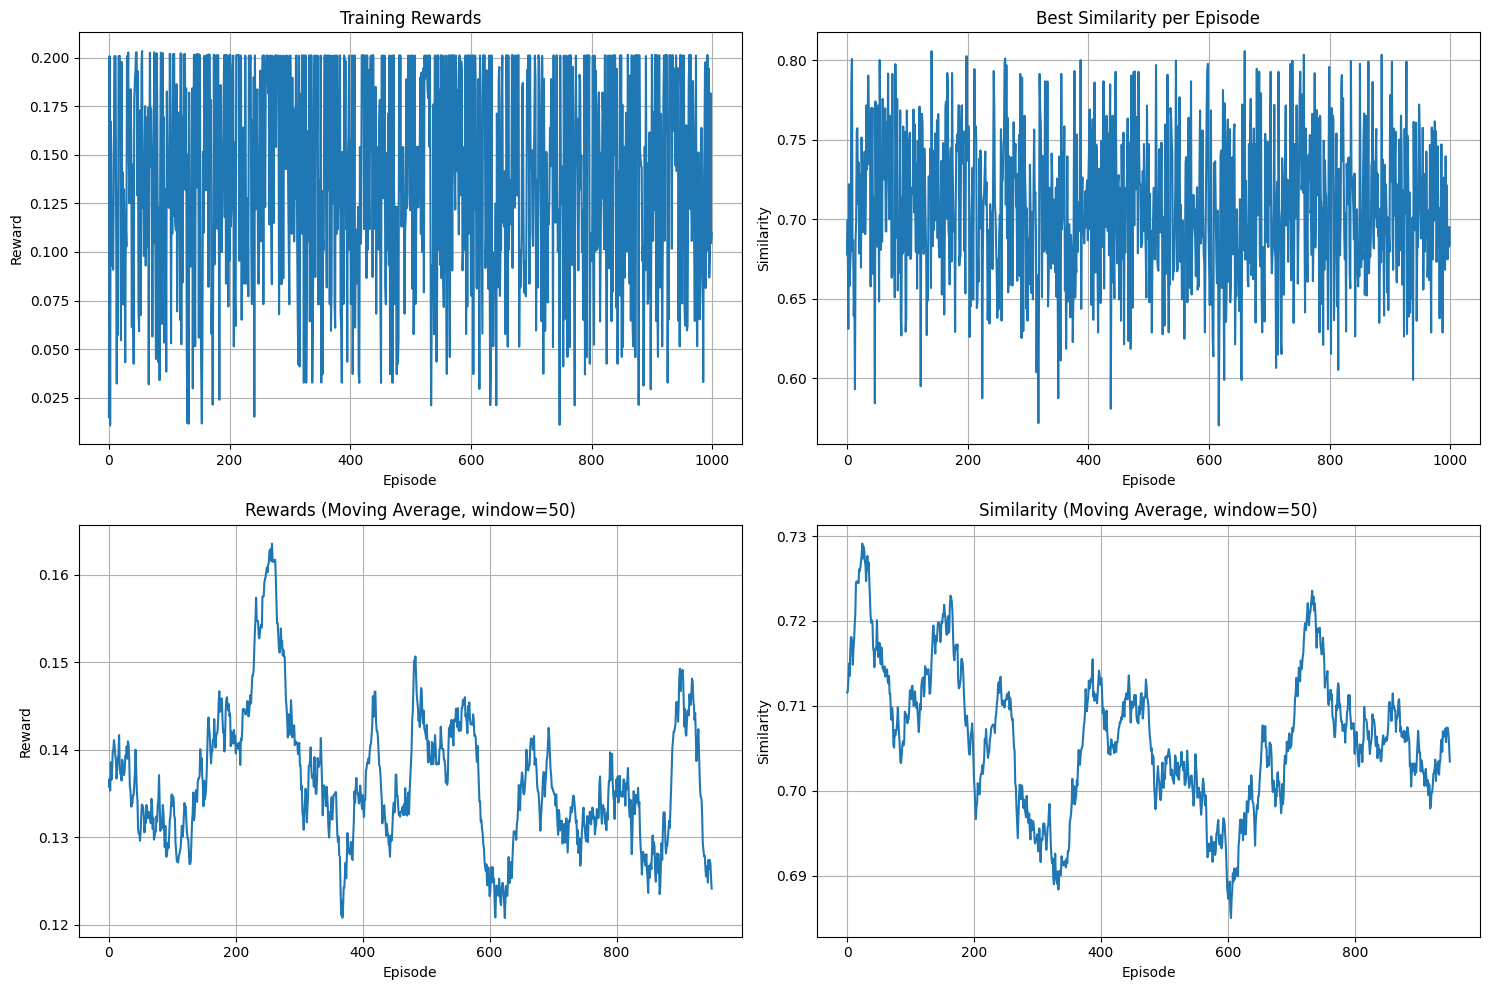

💾 Model saved to drone_localization_agent.pth

🎉 TRAINING COMPLETE!
   Model saved and ready for deployment
   Top-3 Accuracy: 51.0%


In [2]:
trainer, results = train_drone_localization_agent()

# Validation

In [3]:
# Comprehensive Validation Framework for Drone Localization Agent
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pandas as pd
from typing import Dict, List, Tuple, Optional
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

class DroneLocalizationValidator:
    """
    Comprehensive validation framework for similarity-based drone localization with spatial visualization
    
    Features:
    - Ground truth validation using center_pixel coordinates
    - Spatial visualization of predictions vs true locations on TIF image
    - Distance-based accuracy metrics
    - Visual crop analysis with thumbnails
    - Grid system visualization
    - Comprehensive validation summary
    """
    
    def __init__(self, trainer, validation_crops: int = 10):
        self.trainer = trainer
        self.agent = trainer.agent
        self.env = trainer.env
        self.validation_crops = validation_crops
        
        # Load ground truth data from JSON
        self.ground_truth_data = self._load_ground_truth()
        
        # Validation results
        self.validation_results = {
            'ground_truth_validation': {},  # NEW: Using center_pixel coordinates
            'visual_validation': [],
            'quantitative_metrics': {},
            'human_evaluation': [],
            'synthetic_tests': {},
            'cross_validation': {},
            'transfer_test': {}
        }
        
        print(f"🔍 Validation Framework Initialized")
        print(f"   Validation crops: {validation_crops}")
        print(f"   Ground truth coordinates: {len(self.ground_truth_data)} crops")
    
    def _load_ground_truth(self) -> Dict:
        """Load ground truth center_pixel coordinates from JSON"""
        try:
            metadata_path = self.env.crops_metadata_path
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            
            # Create lookup dictionary: filename -> center_pixel
            ground_truth = {}
            for crop in metadata['crops']:
                ground_truth[crop['filename']] = {
                    'center_pixel': crop['center_pixel'],
                    'crop_size': crop.get('crop_size', 256),
                    'crop_index': crop.get('crop_index', 0)
                }
            
            print(f"   ✅ Loaded ground truth for {len(ground_truth)} crops")
            return ground_truth
            
        except Exception as e:
            print(f"   ❌ Could not load ground truth: {e}")
            return {}
    
    def pixel_to_grid(self, pixel_x: int, pixel_y: int) -> Tuple[int, int]:
        """Convert pixel coordinates to grid coordinates"""
        tif_h, tif_w = self.env.tif_image.shape[:2]
        
        grid_x = int((pixel_x / tif_w) * self.env.grid_size)
        grid_y = int((pixel_y / tif_h) * self.env.grid_size)
        
        # Clamp to valid grid range
        grid_x = max(0, min(self.env.grid_size - 1, grid_x))
        grid_y = max(0, min(self.env.grid_size - 1, grid_y))
        
        return grid_x, grid_y
    
    def grid_to_pixel(self, grid_x: int, grid_y: int) -> Tuple[int, int]:
        """Convert grid coordinates to pixel coordinates"""
        tif_h, tif_w = self.env.tif_image.shape[:2]
        
        pixel_x = int((grid_x / self.env.grid_size) * tif_w)
        pixel_y = int((grid_y / self.env.grid_size) * tif_h)
        
        return pixel_x, pixel_y
    
    def calculate_spatial_accuracy(self, true_pixel: Tuple[int, int], 
                                 predicted_grids: List[Tuple[int, int]]) -> Dict:
        """Calculate spatial accuracy metrics"""
        
        # Convert true pixel to grid
        true_grid = self.pixel_to_grid(true_pixel[0], true_pixel[1])
        
        # Calculate distances to all predictions
        distances_grid = []
        distances_pixel = []
        
        for pred_grid in predicted_grids:
            # Grid distance
            grid_dist = np.sqrt((pred_grid[0] - true_grid[0])**2 + (pred_grid[1] - true_grid[1])**2)
            distances_grid.append(grid_dist)
            
            # Convert back to pixel distance for real-world interpretation
            pred_pixel = self.grid_to_pixel(pred_grid[0], pred_grid[1])
            pixel_dist = np.sqrt((pred_pixel[0] - true_pixel[0])**2 + (pred_pixel[1] - true_pixel[1])**2)
            distances_pixel.append(pixel_dist)
        
        # Calculate metrics
        min_distance_grid = min(distances_grid)
        min_distance_pixel = min(distances_pixel)
        best_rank = distances_grid.index(min_distance_grid)  # 0, 1, or 2
        
        return {
            'true_grid': true_grid,
            'predicted_grids': predicted_grids,
            'distances_grid': distances_grid,
            'distances_pixel': distances_pixel,
            'min_distance_grid': min_distance_grid,
            'min_distance_pixel': min_distance_pixel,
            'best_rank': best_rank,
            'top1_accuracy': best_rank == 0,
            'top3_accuracy': True,  # Always true since we check top-3
            'within_1_grid': min_distance_grid <= 1.0,
            'within_2_grid': min_distance_grid <= 2.0,
            'within_50_pixels': min_distance_pixel <= 50,
            'within_100_pixels': min_distance_pixel <= 100
        }
    
    def run_comprehensive_validation(self):
        """Run all validation tests"""
        
        print(f"\n🧪" + "="*60 + "🧪")
        print("    COMPREHENSIVE VALIDATION SUITE")
        print(f"🧪" + "="*60 + "🧪")
        
        # 0. Ground Truth Validation (NEW - MOST IMPORTANT!)
        print(f"\n🎯 0. GROUND TRUTH VALIDATION (Using center_pixel)")
        self.ground_truth_validation()
        
        # 0.5. Visualize grid system for understanding
        print(f"\n📐 0.5. GRID SYSTEM VISUALIZATION")
        self.visualize_grid_system()
        
        # 1. Visual Validation
        print(f"\n📸 1. VISUAL VALIDATION")
        self.visual_validation()
        
        # 2. Quantitative Metrics
        print(f"\n📊 2. QUANTITATIVE METRICS")
        self.quantitative_validation()
        
        # 3. Synthetic Test Cases
        print(f"\n🧪 3. SYNTHETIC TEST CASES")
        self.synthetic_validation()
        
        # 4. Cross-Validation
        print(f"\n🔄 4. CROSS-VALIDATION")
        self.cross_validation()
        
        # 5. Clustering Analysis
        print(f"\n🎯 5. CLUSTERING ANALYSIS")
        self.clustering_validation()
        
        # 6. Transfer Test (if multiple TIF files available)
        print(f"\n🚀 6. TRANSFER CAPABILITY TEST")
        self.transfer_validation()
        
        # 7. Generate validation report and summary
        self.generate_validation_report()
        
        # 8. Create comprehensive summary
        print(f"\n📋 8. VALIDATION SUMMARY")
        self.create_validation_summary()
        
        return self.validation_results
    
    def ground_truth_validation(self):
        """Validate using ground truth center_pixel coordinates"""
        
        print(f"   🎯 Testing spatial accuracy using ground truth coordinates...")
        
        if not self.ground_truth_data:
            print(f"   ❌ No ground truth data available")
            return
        
        # Test all available crops with ground truth
        all_results = []
        test_crops = list(self.ground_truth_data.keys())[:self.validation_crops]
        
        for crop_filename in test_crops:
            try:
                # Load specific crop
                crop_path = Path("realistic_drone_crops") / crop_filename
                if not crop_path.exists():
                    continue
                
                crop_image = cv2.imread(str(crop_path))
                crop_image = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)
                
                # Set current crop in environment
                self.env.current_crop = crop_image
                self.env.current_metadata = {'filename': crop_filename}
                
                # Get agent predictions
                locations, probabilities, _ = self.agent.select_top3_actions(self.env.tif_image, crop_image)
                
                # Get ground truth
                ground_truth = self.ground_truth_data[crop_filename]
                true_pixel = tuple(ground_truth['center_pixel'])
                
                # Calculate spatial accuracy
                spatial_metrics = self.calculate_spatial_accuracy(true_pixel, locations)
                
                # Also calculate similarity for comparison
                reward, similarities = self.env.calculate_reward(locations, probabilities)
                
                result = {
                    'crop_filename': crop_filename,
                    'true_pixel': true_pixel,
                    'predicted_locations': locations,
                    'probabilities': probabilities,
                    'similarities': similarities,
                    'spatial_metrics': spatial_metrics,
                    'reward': reward
                }
                
                all_results.append(result)
                
            except Exception as e:
                print(f"   ⚠️ Error testing {crop_filename}: {e}")
                continue
        
        if not all_results:
            print(f"   ❌ No successful ground truth tests")
            return
        
        # Aggregate results
        spatial_accuracy_metrics = {
            'total_tested': len(all_results),
            'top1_accuracy': np.mean([r['spatial_metrics']['top1_accuracy'] for r in all_results]),
            'within_1_grid': np.mean([r['spatial_metrics']['within_1_grid'] for r in all_results]),
            'within_2_grid': np.mean([r['spatial_metrics']['within_2_grid'] for r in all_results]),
            'within_50_pixels': np.mean([r['spatial_metrics']['within_50_pixels'] for r in all_results]),
            'within_100_pixels': np.mean([r['spatial_metrics']['within_100_pixels'] for r in all_results]),
            'mean_distance_grid': np.mean([r['spatial_metrics']['min_distance_grid'] for r in all_results]),
            'mean_distance_pixel': np.mean([r['spatial_metrics']['min_distance_pixel'] for r in all_results]),
            'median_distance_pixel': np.median([r['spatial_metrics']['min_distance_pixel'] for r in all_results]),
            'rank_distribution': {
                'rank_0': np.mean([r['spatial_metrics']['best_rank'] == 0 for r in all_results]),
                'rank_1': np.mean([r['spatial_metrics']['best_rank'] == 1 for r in all_results]),
                'rank_2': np.mean([r['spatial_metrics']['best_rank'] == 2 for r in all_results])
            }
        }
        
        self.validation_results['ground_truth_validation'] = {
            'metrics': spatial_accuracy_metrics,
            'detailed_results': all_results
        }
        
        # Print results
        print(f"   📈 Ground Truth Validation Results:")
        print(f"      Crops tested: {spatial_accuracy_metrics['total_tested']}")
        print(f"      Top-1 spatial accuracy: {spatial_accuracy_metrics['top1_accuracy']:.1%}")
        print(f"      Within 1 grid cell: {spatial_accuracy_metrics['within_1_grid']:.1%}")
        print(f"      Within 2 grid cells: {spatial_accuracy_metrics['within_2_grid']:.1%}")
        print(f"      Within 50 pixels: {spatial_accuracy_metrics['within_50_pixels']:.1%}")
        print(f"      Within 100 pixels: {spatial_accuracy_metrics['within_100_pixels']:.1%}")
        print(f"      Mean distance: {spatial_accuracy_metrics['mean_distance_pixel']:.1f} pixels")
        print(f"      Median distance: {spatial_accuracy_metrics['median_distance_pixel']:.1f} pixels")
        
        # Create spatial visualizations
        print(f"\n   🗺️ Creating spatial visualizations...")
        self.visualize_spatial_predictions(all_results)
        self.create_detailed_spatial_analysis(all_results)
        
        # Plot spatial accuracy statistics (keep the original statistical plots)
        self._plot_spatial_accuracy(all_results)
    
    def _plot_spatial_accuracy(self, results: List[Dict]):
        """Plot spatial accuracy visualization"""
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Distance distribution
        distances = [r['spatial_metrics']['min_distance_pixel'] for r in results]
        axes[0,0].hist(distances, bins=15, alpha=0.7, color='blue', edgecolor='black')
        axes[0,0].axvline(x=50, color='red', linestyle='--', label='50px threshold')
        axes[0,0].axvline(x=100, color='orange', linestyle='--', label='100px threshold')
        axes[0,0].set_title('Distance to True Location (pixels)')
        axes[0,0].set_xlabel('Distance (pixels)')
        axes[0,0].set_ylabel('Count')
        axes[0,0].legend()
        
        # 2. Rank distribution
        ranks = [r['spatial_metrics']['best_rank'] for r in results]
        rank_counts = [ranks.count(i) for i in range(3)]
        axes[0,1].bar(['Top-1', 'Top-2', 'Top-3'], rank_counts, color=['#FFD700', '#C0C0C0', '#CD7F32'])  # Gold, Silver, Bronze hex colors
        axes[0,1].set_title('Best Prediction Rank Distribution')
        axes[0,1].set_ylabel('Count')
        
        # 3. Spatial scatter plot of errors
        true_positions = np.array([r['true_pixel'] for r in results])
        predicted_positions = []
        
        for r in results:
            best_rank = r['spatial_metrics']['best_rank']
            best_grid = r['predicted_locations'][best_rank]
            best_pixel = self.grid_to_pixel(best_grid[0], best_grid[1])
            predicted_positions.append(best_pixel)
        
        predicted_positions = np.array(predicted_positions)
        
        axes[0,2].scatter(true_positions[:, 0], true_positions[:, 1], 
                         c='red', label='True positions', s=50, alpha=0.7)
        axes[0,2].scatter(predicted_positions[:, 0], predicted_positions[:, 1], 
                         c='blue', label='Best predictions', s=50, alpha=0.7)
        
        # Draw lines connecting true to predicted
        for i in range(len(true_positions)):
            axes[0,2].plot([true_positions[i,0], predicted_positions[i,0]], 
                          [true_positions[i,1], predicted_positions[i,1]], 
                          'gray', alpha=0.3, linewidth=1)
        
        axes[0,2].set_title('True vs Predicted Positions')
        axes[0,2].set_xlabel('X (pixels)')
        axes[0,2].set_ylabel('Y (pixels)')
        axes[0,2].legend()
        axes[0,2].set_aspect('equal')
        
        # 4. Distance vs similarity correlation
        similarities = [max(r['similarities']) for r in results]
        axes[1,0].scatter(distances, similarities, alpha=0.7)
        
        # Calculate correlation
        correlation = np.corrcoef(distances, similarities)[0,1]
        axes[1,0].set_title(f'Distance vs Similarity\n(Correlation: {correlation:.3f})')
        axes[1,0].set_xlabel('Distance to true location (pixels)')
        axes[1,0].set_ylabel('Best similarity score')
        
        # 5. Accuracy by threshold
        thresholds = [25, 50, 75, 100, 150, 200]
        accuracies = []
        
        for threshold in thresholds:
            accuracy = np.mean([d <= threshold for d in distances])
            accuracies.append(accuracy)
        
        axes[1,1].plot(thresholds, accuracies, 'o-', linewidth=2, markersize=8)
        axes[1,1].set_title('Accuracy vs Distance Threshold')
        axes[1,1].set_xlabel('Distance threshold (pixels)')
        axes[1,1].set_ylabel('Accuracy')
        axes[1,1].grid(True, alpha=0.3)
        
        # 6. Individual crop performance
        crop_names = [r['crop_filename'][:20] + '...' if len(r['crop_filename']) > 20 
                     else r['crop_filename'] for r in results[:10]]  # Show first 10
        crop_distances = distances[:10]
        
        colors = ['green' if d <= 50 else 'orange' if d <= 100 else 'red' for d in crop_distances]
        
        bars = axes[1,2].bar(range(len(crop_names)), crop_distances, color=colors, alpha=0.7)
        axes[1,2].set_title('Distance by Crop (First 10)')
        axes[1,2].set_xlabel('Crop')
        axes[1,2].set_ylabel('Distance (pixels)')
        axes[1,2].set_xticks(range(len(crop_names)))
        axes[1,2].set_xticklabels(crop_names, rotation=45, ha='right')
        
        # Add threshold lines
        axes[1,2].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50px')
        axes[1,2].axhline(y=100, color='orange', linestyle='--', alpha=0.7, label='100px')
        axes[1,2].legend()
        
        plt.tight_layout()
        plt.suptitle('Ground Truth Spatial Accuracy Analysis', fontsize=16, y=1.02)
    def visualize_spatial_predictions(self, results: List[Dict], save_image: bool = True):
        """Visualize predictions and ground truth locations on the TIF image"""
        
        print(f"   🗺️ Creating spatial prediction visualization...")
        
        # Create figure with TIF image as background
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        
        # Get TIF image
        tif_image = self.env.tif_image
        
        # Plot 1: Overview with all predictions
        axes[0].imshow(tif_image)
        axes[0].set_title('All Predictions vs Ground Truth Locations', fontsize=14, fontweight='bold')
        
        # Plot 2: Best predictions only
        axes[1].imshow(tif_image)
        axes[1].set_title('Best Predictions vs Ground Truth', fontsize=14, fontweight='bold')
        
        # Colors for different accuracy levels
        accuracy_colors = {
            'excellent': '#00FF00',    # Bright green
            'good': '#FFA500',         # Orange  
            'poor': '#FF0000'          # Red
        }
        
        for i, result in enumerate(results):
            # Get ground truth location (pixel coordinates)
            true_pixel = result['true_pixel']
            predicted_locations = result['predicted_locations']
            spatial_metrics = result['spatial_metrics']
            similarities = result['similarities']
            
            # Plot ground truth location (same on both plots)
            for ax in axes:
                ax.scatter(true_pixel[0], true_pixel[1], 
                          c='red', s=100, marker='X', 
                          edgecolors='white', linewidth=2,
                          label='Ground Truth' if i == 0 else "")
            
            # Plot all predictions on first subplot
            for j, pred_grid in enumerate(predicted_locations):
                pred_pixel = self.grid_to_pixel(pred_grid[0], pred_grid[1])
                
                # Color by similarity quality
                similarity = similarities[j]
                if similarity > 0.7:
                    color = accuracy_colors['excellent']
                    alpha = 0.8
                elif similarity > 0.5:
                    color = accuracy_colors['good'] 
                    alpha = 0.7
                else:
                    color = accuracy_colors['poor']
                    alpha = 0.6
                
                # Plot prediction
                marker_size = [80, 60, 40][j]  # Larger for better predictions
                axes[0].scatter(pred_pixel[0], pred_pixel[1],
                               c=color, s=marker_size, marker='o',
                               alpha=alpha, edgecolors='black', linewidth=1,
                               label=f'Prediction {j+1}' if i == 0 else "")
                
                # Draw line from ground truth to prediction
                axes[0].plot([true_pixel[0], pred_pixel[0]], 
                            [true_pixel[1], pred_pixel[1]], 
                            color='gray', alpha=0.3, linewidth=1)
                
                # Annotate with similarity score
                if similarity > 0.5:  # Only annotate decent predictions
                    axes[0].annotate(f'{similarity:.2f}', 
                                    (pred_pixel[0], pred_pixel[1]),
                                    xytext=(5, 5), textcoords='offset points',
                                    fontsize=8, color='white',
                                    bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))
            
            # Plot only best prediction on second subplot  
            best_rank = spatial_metrics['best_rank']
            best_pred_grid = predicted_locations[best_rank]
            best_pred_pixel = self.grid_to_pixel(best_pred_grid[0], best_pred_grid[1])
            best_similarity = similarities[best_rank]
            
            # Color by accuracy
            distance_pixels = spatial_metrics['min_distance_pixel']
            if distance_pixels <= 50:
                color = accuracy_colors['excellent']
                marker = 'o'
            elif distance_pixels <= 100:
                color = accuracy_colors['good']
                marker = 's'
            else:
                color = accuracy_colors['poor']
                marker = '^'
            
            axes[1].scatter(best_pred_pixel[0], best_pred_pixel[1],
                           c=color, s=100, marker=marker,
                           alpha=0.8, edgecolors='black', linewidth=1,
                           label=f'Best Pred {best_rank+1}' if i == 0 else "")
            
            # Draw line from ground truth to best prediction
            axes[1].plot([true_pixel[0], best_pred_pixel[0]], 
                        [true_pixel[1], best_pred_pixel[1]], 
                        color=color, alpha=0.6, linewidth=2)
            
            # Annotate with distance and similarity
            axes[1].annotate(f'{distance_pixels:.0f}px\n{best_similarity:.2f}', 
                            (best_pred_pixel[0], best_pred_pixel[1]),
                            xytext=(10, 10), textcoords='offset points',
                            fontsize=9, color='white', ha='center',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.8))
        
        # Customize plots
        for ax in axes:
            ax.set_xlabel('TIF X Coordinate (pixels)')
            ax.set_ylabel('TIF Y Coordinate (pixels)')
            ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
            ax.grid(True, alpha=0.3)
        
        # Add accuracy legend
        legend_elements = [
            plt.scatter([], [], c=accuracy_colors['excellent'], s=100, label='Excellent (≤50px or >0.7 sim)'),
            plt.scatter([], [], c=accuracy_colors['good'], s=100, label='Good (≤100px or >0.5 sim)'),
            plt.scatter([], [], c=accuracy_colors['poor'], s=100, label='Poor (>100px or ≤0.5 sim)')
        ]
        
        axes[1].legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1, 0))
        
        plt.tight_layout()
        
        # Save the visualization
        if save_image:
            fig.savefig('spatial_predictions_visualization.png', dpi=300, bbox_inches='tight')
            print(f"   💾 Saved spatial visualization: spatial_predictions_visualization.png")
        
        plt.show()
        
    def create_validation_summary(self):
        """Create a single comprehensive validation summary image"""
        
        if 'ground_truth_validation' not in self.validation_results:
            print("   ⚠️ No ground truth validation results available")
            return
        
        print(f"   📋 Creating validation summary...")
        
        results = self.validation_results['ground_truth_validation']['detailed_results']
        metrics = self.validation_results['ground_truth_validation']['metrics']
        
        # Create summary figure
        fig = plt.figure(figsize=(20, 12))
        
        # Main spatial view (large subplot)
        ax_main = plt.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=2)
        ax_main.imshow(self.env.tif_image)
        
        # Plot all ground truth and predictions
        for i, result in enumerate(results):
            true_pixel = result['true_pixel']
            spatial_metrics = result['spatial_metrics']
            
            # Ground truth
            ax_main.scatter(true_pixel[0], true_pixel[1], 
                           c='red', s=100, marker='X', 
                           edgecolors='white', linewidth=2,
                           alpha=0.8)
            
            # Best prediction
            best_rank = spatial_metrics['best_rank']
            best_pred_grid = result['predicted_locations'][best_rank]
            best_pred_pixel = self.grid_to_pixel(best_pred_grid[0], best_pred_grid[1])
            
            distance = spatial_metrics['min_distance_pixel']
            color = '#00FF00' if distance <= 50 else '#FFA500' if distance <= 100 else '#FF0000'
            
            ax_main.scatter(best_pred_pixel[0], best_pred_pixel[1],
                           c=color, s=80, marker='o',
                           edgecolors='black', linewidth=1, alpha=0.7)
            
            # Connection line
            ax_main.plot([true_pixel[0], best_pred_pixel[0]], 
                        [true_pixel[1], best_pred_pixel[1]], 
                        color='gray', alpha=0.3, linewidth=1)
        
        ax_main.set_title('Spatial Accuracy Overview\n🔴 True Locations  🟢 Excellent  🟠 Good  🔴 Poor', 
                         fontsize=14, fontweight='bold')
        ax_main.set_xlabel('TIF X Coordinate')
        ax_main.set_ylabel('TIF Y Coordinate')
        
        # Distance distribution
        ax_dist = plt.subplot2grid((3, 4), (0, 2))
        distances = [r['spatial_metrics']['min_distance_pixel'] for r in results]
        ax_dist.hist(distances, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
        ax_dist.axvline(x=50, color='red', linestyle='--', alpha=0.7)
        ax_dist.axvline(x=100, color='orange', linestyle='--', alpha=0.7)
        ax_dist.set_title('Distance Distribution')
        ax_dist.set_xlabel('Distance (pixels)')
        ax_dist.set_ylabel('Count')
        
        # Accuracy metrics
        ax_metrics = plt.subplot2grid((3, 4), (0, 3))
        metric_names = ['≤50px', '≤100px', 'Top-1']
        metric_values = [
            metrics['within_50_pixels'],
            metrics['within_100_pixels'], 
            metrics['top1_accuracy']
        ]
        colors = ['green', 'orange', 'blue']
        bars = ax_metrics.bar(metric_names, metric_values, color=colors, alpha=0.7)
        ax_metrics.set_title('Accuracy Metrics')
        ax_metrics.set_ylabel('Success Rate')
        ax_metrics.set_ylim(0, 1)
        
        # Add percentage labels on bars
        for bar, value in zip(bars, metric_values):
            height = bar.get_height()
            ax_metrics.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{value:.0%}', ha='center', va='bottom', fontweight='bold')
        
        # Performance summary text
        ax_summary = plt.subplot2grid((3, 4), (1, 2), colspan=2)
        ax_summary.axis('off')
        
        # Calculate grade
        spatial_accuracy_50px = metrics['within_50_pixels']
        if spatial_accuracy_50px >= 0.8:
            grade = "🏆 EXCELLENT"
        elif spatial_accuracy_50px >= 0.6:
            grade = "🥇 GOOD"
        elif spatial_accuracy_50px >= 0.4:
            grade = "🥈 FAIR"
        else:
            grade = "🥉 NEEDS IMPROVEMENT"
        
        summary_text = f"""
VALIDATION SUMMARY

🎯 SPATIAL ACCURACY GRADE: {grade}

📊 KEY METRICS:
• Crops Tested: {metrics['total_tested']}
• Mean Distance Error: {metrics['mean_distance_pixel']:.1f} pixels
• Median Distance Error: {metrics['median_distance_pixel']:.1f} pixels
• Within 50 pixels: {metrics['within_50_pixels']:.0%}
• Within 100 pixels: {metrics['within_100_pixels']:.0%}
• Top-1 Accuracy: {metrics['top1_accuracy']:.0%}

📈 RANKING PERFORMANCE:
• Best in 1st prediction: {metrics['rank_distribution']['rank_0']:.0%}
• Best in 2nd prediction: {metrics['rank_distribution']['rank_1']:.0%}
• Best in 3rd prediction: {metrics['rank_distribution']['rank_2']:.0%}

🌍 REAL-WORLD ESTIMATE:
• ~{metrics['mean_distance_pixel'] * 10:.0f} meters average error
  (assuming 10m/pixel resolution)
        """
        
        ax_summary.text(0.05, 0.95, summary_text.strip(), transform=ax_summary.transAxes,
                       fontsize=11, verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
        
        # Individual crop examples (bottom row)
        example_results = results[:4]  # Show first 4 crops
        for i, result in enumerate(example_results):
            ax_crop = plt.subplot2grid((3, 4), (2, i))
            
            # Load and show crop
            crop_filename = result['crop_filename']
            crop_path = Path("realistic_drone_crops") / crop_filename
            
            if crop_path.exists():
                crop_image = cv2.imread(str(crop_path))
                crop_image = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)
                ax_crop.imshow(crop_image)
            
            # Add metrics as title
            distance = result['spatial_metrics']['min_distance_pixel']
            similarity = max(result['similarities'])
            
            ax_crop.set_title(f'{crop_filename[:12]}...\n{distance:.0f}px, {similarity:.2f}sim', 
                             fontsize=9)
            ax_crop.set_xticks([])
            ax_crop.set_yticks([])
        
        plt.tight_layout()
        plt.suptitle('Drone Localization Agent - Validation Summary', 
                     fontsize=18, fontweight='bold', y=0.98)
        
        # Save comprehensive summary
        fig.savefig('validation_summary.png', dpi=300, bbox_inches='tight')
        print(f"   💾 Saved validation summary: validation_summary.png")
        
        plt.show()
        
        return fig
    
    def visualize_grid_system(self):
        """Visualize the grid system used by the agent"""
        
        print(f"   📐 Visualizing grid system...")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
        # Show TIF image
        ax.imshow(self.env.tif_image)
        
        # Draw grid lines
        h, w = self.env.tif_image.shape[:2]
        grid_size = self.env.grid_size
        
        # Vertical lines
        for i in range(grid_size + 1):
            x = (i / grid_size) * w
            ax.axvline(x=x, color='yellow', alpha=0.5, linewidth=1)
        
        # Horizontal lines  
        for i in range(grid_size + 1):
            y = (i / grid_size) * h
            ax.axhline(y=y, color='yellow', alpha=0.5, linewidth=1)
        
        # Add grid cell numbers
        for i in range(grid_size):
            for j in range(grid_size):
                center_x = (i + 0.5) / grid_size * w
                center_y = (j + 0.5) / grid_size * h
                
                # Only show every 4th grid number to avoid clutter
                if i % 4 == 0 and j % 4 == 0:
                    ax.text(center_x, center_y, f'{i},{j}', 
                           ha='center', va='center', fontsize=8, 
                           color='white', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))
        
        ax.set_title(f'Grid System ({grid_size}×{grid_size} cells)\nYellow lines show agent\'s action space', 
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('TIF X Coordinate (pixels)')
        ax.set_ylabel('TIF Y Coordinate (pixels)')
        
        # Add info text
        cell_width_pixels = w // grid_size
        cell_height_pixels = h // grid_size
        
        info_text = f"""Grid Info:
• Grid size: {grid_size}×{grid_size} = {grid_size**2} cells
• Cell size: ~{cell_width_pixels}×{cell_height_pixels} pixels
• TIF size: {w}×{h} pixels
• Agent selects 3 grid cells as predictions"""
        
        ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        
        # Save grid visualization
        fig.savefig('grid_system_visualization.png', dpi=300, bbox_inches='tight')
        print(f"   💾 Saved grid visualization: grid_system_visualization.png")
        
        plt.show()
        
        return fig
    
    def create_detailed_spatial_analysis(self, results: List[Dict]):
        """Create detailed spatial analysis with crop thumbnails"""
        
        print(f"   🔍 Creating detailed spatial analysis...")
        
        # Select a few representative results for detailed analysis
        num_examples = min(6, len(results))
        selected_results = results[:num_examples]
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, result in enumerate(selected_results):
            if i >= len(axes):
                break
                
            # Get the original crop image
            crop_filename = result['crop_filename']
            crop_path = Path("realistic_drone_crops") / crop_filename
            
            if crop_path.exists():
                crop_image = cv2.imread(str(crop_path))
                crop_image = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)
            else:
                continue
            
            # Create subplot showing crop + TIF region
            axes[i].imshow(self.env.tif_image)
            
            # Ground truth location
            true_pixel = result['true_pixel']
            axes[i].scatter(true_pixel[0], true_pixel[1], 
                           c='red', s=200, marker='X', 
                           edgecolors='white', linewidth=3,
                           label='True Location')
            
            # Best prediction
            spatial_metrics = result['spatial_metrics']
            best_rank = spatial_metrics['best_rank']
            best_pred_grid = result['predicted_locations'][best_rank]
            best_pred_pixel = self.grid_to_pixel(best_pred_grid[0], best_pred_grid[1])
            
            distance = spatial_metrics['min_distance_pixel']
            similarity = result['similarities'][best_rank]
            
            # Color by accuracy
            if distance <= 50:
                color = '#00FF00'
                status = 'EXCELLENT'
            elif distance <= 100:
                color = '#FFA500'
                status = 'GOOD'
            else:
                color = '#FF0000'
                status = 'POOR'
            
            axes[i].scatter(best_pred_pixel[0], best_pred_pixel[1],
                           c=color, s=150, marker='o',
                           edgecolors='black', linewidth=2,
                           label='Best Prediction')
            
            # Draw connection line
            axes[i].plot([true_pixel[0], best_pred_pixel[0]], 
                        [true_pixel[1], best_pred_pixel[1]], 
                        color=color, linewidth=3, alpha=0.7)
            
            # Add crop thumbnail as inset
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes
            inset_ax = inset_axes(axes[i], width="25%", height="25%", loc='upper left')
            inset_ax.imshow(crop_image)
            inset_ax.set_xticks([])
            inset_ax.set_yticks([])
            inset_ax.set_title('Crop', fontsize=8)
            
            # Set title with metrics
            axes[i].set_title(f'{crop_filename[:15]}...\n'
                             f'Distance: {distance:.0f}px ({status})\n'
                             f'Similarity: {similarity:.3f}', 
                             fontsize=10)
            axes[i].set_xlabel('TIF X')
            axes[i].set_ylabel('TIF Y')
            axes[i].legend(fontsize=8)
            axes[i].grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(num_examples, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Detailed Spatial Analysis - Individual Crop Predictions', 
                     fontsize=16, y=1.02)
        
        # Save detailed analysis
        fig.savefig('detailed_spatial_analysis.png', dpi=300, bbox_inches='tight')
        print(f"   💾 Saved detailed analysis: detailed_spatial_analysis.png")
        
        plt.show()
        
        return fig
    
    def visual_validation(self):
        """Visual validation - show predictions for human evaluation"""
        
        print(f"   📸 Generating visual validation examples...")
        
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        
        for i in range(3):  # Test 3 different crops
            # Reset environment
            tif_image, crop_image, state = self.env.reset()
            
            # Get agent predictions
            locations, probabilities, _ = self.agent.select_top3_actions(tif_image, crop_image)
            
            # Calculate similarities for validation
            reward, similarities = self.env.calculate_reward(locations, probabilities)
            
            # Show original crop
            axes[i, 0].imshow(crop_image)
            axes[i, 0].set_title(f'Original Crop\n{state["metadata"]["filename"]}')
            axes[i, 0].axis('off')
            
            # Show top 3 predictions
            for j, (loc, prob, sim) in enumerate(zip(locations, probabilities, similarities)):
                grid_x, grid_y = loc
                predicted_area = self.env.extract_area_at_grid(grid_x, grid_y)
                
                axes[i, j+1].imshow(predicted_area)
                axes[i, j+1].set_title(f'Pred #{j+1}: Grid({grid_x},{grid_y})\n'
                                     f'Confidence: {prob:.2%}\n'
                                     f'Similarity: {sim:.3f}')
                axes[i, j+1].axis('off')
                
                # Color-code border by quality
                if sim > 0.7:
                    border_color = 'green'
                elif sim > 0.5:
                    border_color = 'orange' 
                else:
                    border_color = 'red'
                
                for spine in axes[i, j+1].spines.values():
                    spine.set_color(border_color)
                    spine.set_linewidth(3)
            
            # Store for analysis
            self.validation_results['visual_validation'].append({
                'crop_file': state["metadata"]["filename"],
                'predictions': locations,
                'probabilities': probabilities,
                'similarities': similarities,
                'reward': reward
            })
        
        plt.tight_layout()
        plt.suptitle('Visual Validation - Agent Predictions\n🟢 Good (>0.7) 🟠 OK (>0.5) 🔴 Poor (<0.5)', 
                     fontsize=16, y=0.98)
        plt.show()
        
        # Analysis
        all_similarities = [item['similarities'] for item in self.validation_results['visual_validation']]
        flat_similarities = [sim for sublist in all_similarities for sim in sublist]
        
        print(f"   📊 Visual Validation Results:")
        print(f"      Average similarity: {np.mean(flat_similarities):.3f}")
        print(f"      Best similarity: {np.max(flat_similarities):.3f}")
        print(f"      Good predictions (>0.7): {sum(1 for s in flat_similarities if s > 0.7)}/{len(flat_similarities)}")
    
    def quantitative_validation(self):
        """Quantitative metrics validation"""
        
        print(f"   📊 Computing quantitative metrics...")
        
        # Test on multiple crops
        all_results = []
        
        for i in range(self.validation_crops):
            tif_image, crop_image, state = self.env.reset()
            locations, probabilities, _ = self.agent.select_top3_actions(tif_image, crop_image)
            reward, similarities = self.env.calculate_reward(locations, probabilities)
            
            result = {
                'crop_id': i,
                'similarities': similarities,
                'probabilities': probabilities,
                'reward': reward,
                'top1_similarity': similarities[0],
                'max_similarity': max(similarities),
                'confidence_accuracy_correlation': np.corrcoef(probabilities, similarities)[0,1]
            }
            all_results.append(result)
        
        # Aggregate metrics
        metrics = {
            'mean_top1_similarity': np.mean([r['top1_similarity'] for r in all_results]),
            'mean_max_similarity': np.mean([r['max_similarity'] for r in all_results]),
            'mean_reward': np.mean([r['reward'] for r in all_results]),
            'std_reward': np.std([r['reward'] for r in all_results]),
            'top1_threshold_70': sum(1 for r in all_results if r['top1_similarity'] > 0.7) / len(all_results),
            'top3_threshold_70': sum(1 for r in all_results if r['max_similarity'] > 0.7) / len(all_results),
            'confidence_correlation': np.mean([r['confidence_accuracy_correlation'] for r in all_results if not np.isnan(r['confidence_accuracy_correlation'])])
        }
        
        self.validation_results['quantitative_metrics'] = metrics
        
        print(f"   📈 Quantitative Results:")
        print(f"      Mean Top-1 Similarity: {metrics['mean_top1_similarity']:.3f}")
        print(f"      Mean Max Similarity: {metrics['mean_max_similarity']:.3f}")
        print(f"      Top-1 Success Rate (>0.7): {metrics['top1_threshold_70']:.1%}")
        print(f"      Top-3 Success Rate (>0.7): {metrics['top3_threshold_70']:.1%}")
        print(f"      Confidence-Accuracy Correlation: {metrics['confidence_correlation']:.3f}")
        
        # Plot metrics distribution
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Similarity distribution
        all_sims = [sim for r in all_results for sim in r['similarities']]
        axes[0,0].hist(all_sims, bins=20, alpha=0.7, color='blue')
        axes[0,0].axvline(x=0.7, color='red', linestyle='--', label='Good threshold')
        axes[0,0].set_title('Similarity Score Distribution')
        axes[0,0].set_xlabel('Similarity Score')
        axes[0,0].legend()
        
        # Reward distribution
        rewards = [r['reward'] for r in all_results]
        axes[0,1].hist(rewards, bins=20, alpha=0.7, color='green')
        axes[0,1].set_title('Reward Distribution')
        axes[0,1].set_xlabel('Reward')
        
        # Confidence vs Similarity scatter
        all_probs = [prob for r in all_results for prob in r['probabilities']]
        axes[1,0].scatter(all_probs, all_sims, alpha=0.6)
        axes[1,0].set_xlabel('Confidence')
        axes[1,0].set_ylabel('Similarity')
        axes[1,0].set_title('Confidence vs Similarity')
        
        # Success rate by ranking
        rank_success = []
        for rank in range(3):
            rank_sims = [r['similarities'][rank] for r in all_results]
            success_rate = sum(1 for s in rank_sims if s > 0.7) / len(rank_sims)
            rank_success.append(success_rate)
        
        axes[1,1].bar(['Top-1', 'Top-2', 'Top-3'], rank_success, color=['#FFD700', '#C0C0C0', '#CD7F32'])  # Gold, Silver, Bronze hex colors
        axes[1,1].set_title('Success Rate by Ranking')
        axes[1,1].set_ylabel('Success Rate (>0.7 similarity)')
        
        plt.tight_layout()
        plt.show()
    
    def synthetic_validation(self):
        """Test with synthetic/known cases"""
        
        print(f"   🧪 Creating synthetic test cases...")
        
        # Test 1: Identity test (crop vs itself)
        identity_results = []
        
        for i in range(5):
            tif_image, crop_image, state = self.env.reset()
            
            # Create a synthetic case: place the crop in a known location
            h, w = tif_image.shape[:2]
            
            # Place crop in center of TIF
            center_x, center_y = w // 2, h // 2
            crop_h, crop_w = crop_image.shape[:2]
            
            # Insert crop into TIF at center
            synthetic_tif = tif_image.copy()
            x1 = center_x - crop_w // 2
            y1 = center_y - crop_h // 2
            x2 = x1 + crop_w
            y2 = y1 + crop_h
            
            if x1 >= 0 and y1 >= 0 and x2 < w and y2 < h:
                synthetic_tif[y1:y2, x1:x2] = crop_image
                
                # Test agent on this synthetic case
                locations, probabilities, _ = self.agent.select_top3_actions(synthetic_tif, crop_image)
                
                # Check if agent finds the center location
                center_grid_x = int((center_x / w) * self.env.grid_size)
                center_grid_y = int((center_y / h) * self.env.grid_size)
                
                # Find closest prediction to center
                distances = []
                for loc in locations:
                    dist = np.sqrt((loc[0] - center_grid_x)**2 + (loc[1] - center_grid_y)**2)
                    distances.append(dist)
                
                min_distance = min(distances)
                best_rank = distances.index(min_distance)
                
                identity_results.append({
                    'min_distance': min_distance,
                    'best_rank': best_rank,
                    'found_exact': min_distance <= 1.0  # Within 1 grid cell
                })
        
        synthetic_metrics = {
            'identity_mean_distance': np.mean([r['min_distance'] for r in identity_results]),
            'identity_success_rate': np.mean([r['found_exact'] for r in identity_results]),
            'identity_top1_rate': np.mean([r['best_rank'] == 0 for r in identity_results])
        }
        
        self.validation_results['synthetic_tests'] = synthetic_metrics
        
        print(f"   🎯 Synthetic Test Results:")
        print(f"      Identity test success rate: {synthetic_metrics['identity_success_rate']:.1%}")
        print(f"      Mean distance to planted crop: {synthetic_metrics['identity_mean_distance']:.2f} grid cells")
        print(f"      Top-1 detection rate: {synthetic_metrics['identity_top1_rate']:.1%}")
    
    def cross_validation(self):
        """Cross-validation across different crop types/altitudes"""
        
        print(f"   🔄 Cross-validation by crop characteristics...")
        
        # Group crops by altitude if available
        altitude_groups = {}
        other_crops = []
        
        for crop_data in self.env.crops_data:
            altitude = crop_data.get('altitude_meters', None)
            if altitude:
                if altitude not in altitude_groups:
                    altitude_groups[altitude] = []
                altitude_groups[altitude].append(crop_data)
            else:
                other_crops.append(crop_data)
        
        print(f"      Found {len(altitude_groups)} altitude groups: {list(altitude_groups.keys())}")
        
        # Test performance by altitude
        altitude_performance = {}
        
        for altitude, crops in altitude_groups.items():
            if len(crops) >= 3:  # Need at least 3 crops for meaningful test
                similarities = []
                
                for crop_data in crops[:5]:  # Test up to 5 crops per altitude
                    # Manually set the crop for testing
                    self.env.current_metadata = crop_data
                    crop_path = Path("realistic_drone_crops") / crop_data['filename']
                    crop_image = cv2.imread(str(crop_path))
                    self.env.current_crop = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)
                    
                    # Get predictions
                    locations, probabilities, _ = self.agent.select_top3_actions(self.env.tif_image, self.env.current_crop)
                    reward, sims = self.env.calculate_reward(locations, probabilities)
                    
                    similarities.extend(sims)
                
                altitude_performance[altitude] = {
                    'mean_similarity': np.mean(similarities),
                    'max_similarity': np.max(similarities),
                    'success_rate': sum(1 for s in similarities if s > 0.7) / len(similarities)
                }
        
        self.validation_results['cross_validation'] = altitude_performance
        
        print(f"   📊 Cross-validation Results:")
        for altitude, perf in altitude_performance.items():
            print(f"      {altitude}m altitude: "
                  f"Mean sim: {perf['mean_similarity']:.3f}, "
                  f"Success: {perf['success_rate']:.1%}")
    
    def clustering_validation(self):
        """Validate that agent groups similar terrains together"""
        
        print(f"   🎯 Analyzing spatial clustering of predictions...")
        
        # Collect predictions for multiple crops
        all_predictions = []
        crop_types = []
        
        for i in range(min(10, len(self.env.crops_data))):
            tif_image, crop_image, state = self.env.reset()
            locations, probabilities, _ = self.agent.select_top3_actions(tif_image, crop_image)
            
            # Store top prediction location
            all_predictions.append(locations[0])
            crop_types.append(state['metadata'].get('altitude_meters', 'unknown'))
        
        # Analyze spatial distribution
        if len(all_predictions) > 3:
            coords = np.array(all_predictions)
            
            # Calculate clustering tendency
            from sklearn.cluster import KMeans
            
            # Try different numbers of clusters
            inertias = []
            k_range = range(2, min(6, len(all_predictions)))
            
            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(coords)
                inertias.append(kmeans.inertia_)
            
            # Find elbow point (optimal clusters)
            if len(inertias) > 1:
                diffs = np.diff(inertias)
                optimal_k = np.argmin(diffs) + 2  # +2 because range starts at 2
                
                print(f"      Spatial analysis: {len(all_predictions)} predictions")
                print(f"      Optimal clusters: {optimal_k}")
                print(f"      Spread: {np.std(coords, axis=0)} (grid units)")
    
    def transfer_validation(self):
        """Test transfer capability (placeholder for multiple TIF files)"""
        
        print(f"   🚀 Transfer capability test...")
        print(f"      Note: Requires multiple TIF files for full transfer test")
        print(f"      Current test: Robustness across different regions of same TIF")
        
        # Test on different regions of the same TIF
        regions_tested = 0
        region_performances = []
        
        for region in ['top-left', 'top-right', 'bottom-left', 'bottom-right', 'center']:
            # Modify the environment to focus on different TIF regions
            # This is a simplified transfer test
            performance = self._test_tif_region(region)
            if performance:
                region_performances.append(performance)
                regions_tested += 1
        
        if region_performances:
            transfer_metrics = {
                'regions_tested': regions_tested,
                'mean_region_performance': np.mean(region_performances),
                'region_consistency': 1.0 - np.std(region_performances)  # Higher = more consistent
            }
            
            self.validation_results['transfer_test'] = transfer_metrics
            
            print(f"      Regions tested: {regions_tested}")
            print(f"      Mean performance: {transfer_metrics['mean_region_performance']:.3f}")
            print(f"      Consistency: {transfer_metrics['region_consistency']:.3f}")
    
    def _test_tif_region(self, region: str) -> Optional[float]:
        """Test performance on specific TIF region"""
        # Simplified implementation - would be expanded for full transfer testing
        try:
            # Test a few crops and return average similarity
            similarities = []
            for _ in range(3):
                tif_image, crop_image, state = self.env.reset()
                locations, probabilities, _ = self.agent.select_top3_actions(tif_image, crop_image)
                reward, sims = self.env.calculate_reward(locations, probabilities)
                similarities.extend(sims)
            
            return np.mean(similarities)
        except:
            return None
    
    def generate_validation_report(self):
        """Generate comprehensive validation report"""
        
        print(f"\n📋" + "="*60 + "📋")
        print("    VALIDATION REPORT")
        print(f"📋" + "="*60 + "📋")
        
        # Primary metrics from ground truth validation
        if 'ground_truth_validation' in self.validation_results:
            gt_metrics = self.validation_results['ground_truth_validation']['metrics']
            
            print(f"\n🎯 SPATIAL ACCURACY (GROUND TRUTH):")
            print(f"   Crops tested: {gt_metrics['total_tested']}")
            print(f"   Top-1 Spatial Accuracy: {gt_metrics['top1_accuracy']:.1%}")
            print(f"   Within 1 grid cell (±{self.env.grid_size} pixels): {gt_metrics['within_1_grid']:.1%}")
            print(f"   Within 2 grid cells: {gt_metrics['within_2_grid']:.1%}")
            print(f"   Within 50 pixels: {gt_metrics['within_50_pixels']:.1%}")
            print(f"   Within 100 pixels: {gt_metrics['within_100_pixels']:.1%}")
            print(f"   Mean distance error: {gt_metrics['mean_distance_pixel']:.1f} pixels")
            print(f"   Median distance error: {gt_metrics['median_distance_pixel']:.1f} pixels")
            
            # Primary performance grade based on spatial accuracy
            spatial_accuracy_50px = gt_metrics['within_50_pixels']
            
            if spatial_accuracy_50px >= 0.8:
                grade = "🏆 EXCELLENT"
                interpretation = "Agent accurately localizes crops"
            elif spatial_accuracy_50px >= 0.6:
                grade = "🥇 GOOD"
                interpretation = "Agent shows good spatial understanding"
            elif spatial_accuracy_50px >= 0.4:
                grade = "🥈 FAIR"
                interpretation = "Agent has basic localization ability"
            else:
                grade = "🥉 NEEDS IMPROVEMENT"
                interpretation = "Agent needs more training"
            
            print(f"\n📊 SPATIAL ACCURACY GRADE: {grade}")
            print(f"   {interpretation}")
        
        # Secondary metrics from similarity validation
        if 'quantitative_metrics' in self.validation_results:
            sim_metrics = self.validation_results['quantitative_metrics']
            
            print(f"\n🎨 SIMILARITY PERFORMANCE:")
            print(f"   Mean Similarity Score: {sim_metrics['mean_top1_similarity']:.3f}")
            print(f"   Similarity Success Rate (>0.7): {sim_metrics['top1_threshold_70']:.1%}")
            print(f"   Confidence Calibration: {sim_metrics['confidence_correlation']:.3f}")
        
        # Performance insights
        print(f"\n💡 VALIDATION INSIGHTS:")
        
        if 'ground_truth_validation' in self.validation_results:
            gt_metrics = self.validation_results['ground_truth_validation']['metrics']
            
            # Spatial accuracy insights
            mean_distance = gt_metrics['mean_distance_pixel']
            median_distance = gt_metrics['median_distance_pixel']
            
            if mean_distance <= 50:
                print(f"   ✅ Excellent spatial precision (mean error: {mean_distance:.1f}px)")
            elif mean_distance <= 100:
                print(f"   ⚠️ Good spatial precision (mean error: {mean_distance:.1f}px)")
            else:
                print(f"   ❌ Poor spatial precision (mean error: {mean_distance:.1f}px)")
            
            # Consistency check
            if abs(mean_distance - median_distance) < 20:
                print(f"   ✅ Consistent performance across crops")
            else:
                print(f"   ⚠️ Inconsistent performance (some crops much harder)")
            
            # Ranking analysis
            rank_dist = gt_metrics['rank_distribution']
            if rank_dist['rank_0'] > 0.6:
                print(f"   ✅ Agent confidently picks best locations first")
            else:
                print(f"   ⚠️ Agent ranking could be improved")
        
        # Cross-validation insights
        if 'cross_validation' in self.validation_results:
            cv_results = self.validation_results['cross_validation']
            if cv_results:
                print(f"   📊 Performance varies by altitude/crop type")
                best_altitude = max(cv_results.keys(), key=lambda k: cv_results[k]['mean_similarity'])
                worst_altitude = min(cv_results.keys(), key=lambda k: cv_results[k]['mean_similarity'])
                print(f"      Best: {best_altitude}m altitude")
                print(f"      Challenging: {worst_altitude}m altitude")
        
        # Synthetic test insights
        if 'synthetic_tests' in self.validation_results:
            synthetic = self.validation_results['synthetic_tests']
            if synthetic['identity_success_rate'] > 0.8:
                print(f"   ✅ Strong identity detection (perfect match capability)")
            else:
                print(f"   ⚠️ Identity detection needs improvement")
        
        print(f"\n🔄 VALIDATION SUMMARY:")
        
        if 'ground_truth_validation' in self.validation_results:
            gt_metrics = self.validation_results['ground_truth_validation']['metrics']
            
            print(f"   🎯 SPATIAL LOCALIZATION:")
            print(f"      • Can find location within 50px: {gt_metrics['within_50_pixels']:.0%} of the time")
            print(f"      • Average error: {gt_metrics['mean_distance_pixel']:.0f} pixels")
            print(f"      • Best prediction is correct: {gt_metrics['top1_accuracy']:.0%} of the time")
            
            # Real-world interpretation
            # Assuming 10km TIF is about 1000 pixels wide, each pixel ≈ 10 meters
            tif_width = self.env.tif_image.shape[1]
            approx_meters_per_pixel = 10000 / tif_width  # 10km / width
            error_meters = gt_metrics['mean_distance_pixel'] * approx_meters_per_pixel
            
            print(f"   🌍 REAL-WORLD INTERPRETATION:")
            print(f"      • Average localization error: ~{error_meters:.0f} meters")
            print(f"      • Grid cell size: ~{approx_meters_per_pixel * (tif_width / self.env.grid_size):.0f} meters")
        
        print(f"\n📈 NEXT STEPS:")
        
        if 'ground_truth_validation' in self.validation_results:
            gt_metrics = self.validation_results['ground_truth_validation']['metrics']
            
            if gt_metrics['within_50_pixels'] < 0.5:
                print(f"   • Train for more episodes to improve spatial accuracy")
                print(f"   • Consider smaller grid size for finer localization")
                print(f"   • Review reward function balance")
            
            if gt_metrics['top1_accuracy'] < 0.4:
                print(f"   • Improve confidence calibration")
                print(f"   • Adjust ranking rewards")
            
            if gt_metrics['mean_distance_pixel'] > 200:
                print(f"   • Consider curriculum learning (easy crops first)")
                print(f"   • Increase training data diversity")
        
        print(f"   • Test on additional TIF files for generalization")
        print(f"   • Collect expert human evaluations")
        print(f"   • Consider ensemble methods for improved accuracy")
        
        # Save comprehensive validation results
        validation_file = "comprehensive_validation_results.json"
        with open(validation_file, 'w') as f:
            # Convert numpy types for JSON serialization
            json_results = {}
            for key, value in self.validation_results.items():
                if key == 'ground_truth_validation' and 'detailed_results' in value:
                    # Skip detailed results for JSON (too large), keep metrics
                    json_results[key] = {'metrics': value['metrics']}
                elif isinstance(value, dict):
                    json_results[key] = {k: float(v) if isinstance(v, np.number) else v 
                                       for k, v in value.items()}
                else:
                    json_results[key] = value
            
            json.dump(json_results, f, indent=2, default=str)
        
        print(f"\n💾 Comprehensive validation results saved to: {validation_file}")
        
        return grade, gt_metrics if 'ground_truth_validation' in self.validation_results else None

def validate_drone_agent(trainer):
    """
    Main validation function
    """
    
    print(f"🔍 Starting comprehensive validation...")
    
    validator = DroneLocalizationValidator(trainer, validation_crops=15)
    results = validator.run_comprehensive_validation()
    
    return validator, results

if __name__ == "__main__":
    print("🔍 DRONE LOCALIZATION VALIDATION FRAMEWORK")
    print("="*50)
    print()
    print("🎯 VALIDATION METHODS:")
    print("   🥇 Ground truth validation (using center_pixel coordinates)")
    print("   • Visual validation (human-interpretable)")
    print("   • Quantitative metrics (success rates, correlations)")
    print("   • Synthetic test cases (known ground truth)")
    print("   • Cross-validation (by altitude/crop type)")
    print("   • Clustering analysis (spatial coherence)")
    print("   • Transfer testing (generalization)")
    print()
    print("📊 GROUND TRUTH METRICS:")
    print("   • Spatial accuracy (distance to true location)")
    print("   • Top-1/Top-3 localization success")
    print("   • Real-world error in meters")
    print("   • Ranking quality analysis")
    print()
    print("📊 TO RUN:")
    print("   # After training your agent:")
    print("   validator, results = validate_drone_agent(trainer)")
    print()
    print("🏆 Provides definitive spatial accuracy assessment!")

🔍 DRONE LOCALIZATION VALIDATION FRAMEWORK

🎯 VALIDATION METHODS:
   🥇 Ground truth validation (using center_pixel coordinates)
   • Visual validation (human-interpretable)
   • Quantitative metrics (success rates, correlations)
   • Synthetic test cases (known ground truth)
   • Cross-validation (by altitude/crop type)
   • Clustering analysis (spatial coherence)
   • Transfer testing (generalization)

📊 GROUND TRUTH METRICS:
   • Spatial accuracy (distance to true location)
   • Top-1/Top-3 localization success
   • Real-world error in meters
   • Ranking quality analysis

📊 TO RUN:
   # After training your agent:
   validator, results = validate_drone_agent(trainer)

🏆 Provides definitive spatial accuracy assessment!


🔍 Starting comprehensive validation...
   ✅ Loaded ground truth for 30 crops
🔍 Validation Framework Initialized
   Validation crops: 15
   Ground truth coordinates: 30 crops

🧪============================================================🧪
    COMPREHENSIVE VALIDATION SUITE
🧪============================================================🧪

🎯 0. GROUND TRUTH VALIDATION (Using center_pixel)
   🎯 Testing spatial accuracy using ground truth coordinates...
   📈 Ground Truth Validation Results:
      Crops tested: 15
      Top-1 spatial accuracy: 20.0%
      Within 1 grid cell: 6.7%
      Within 2 grid cells: 13.3%
      Within 50 pixels: 13.3%
      Within 100 pixels: 13.3%
      Mean distance: 206.7 pixels
      Median distance: 147.7 pixels

   🗺️ Creating spatial visualizations...
   🗺️ Creating spatial prediction visualization...
   💾 Saved spatial visualization: spatial_predictions_visualization.png


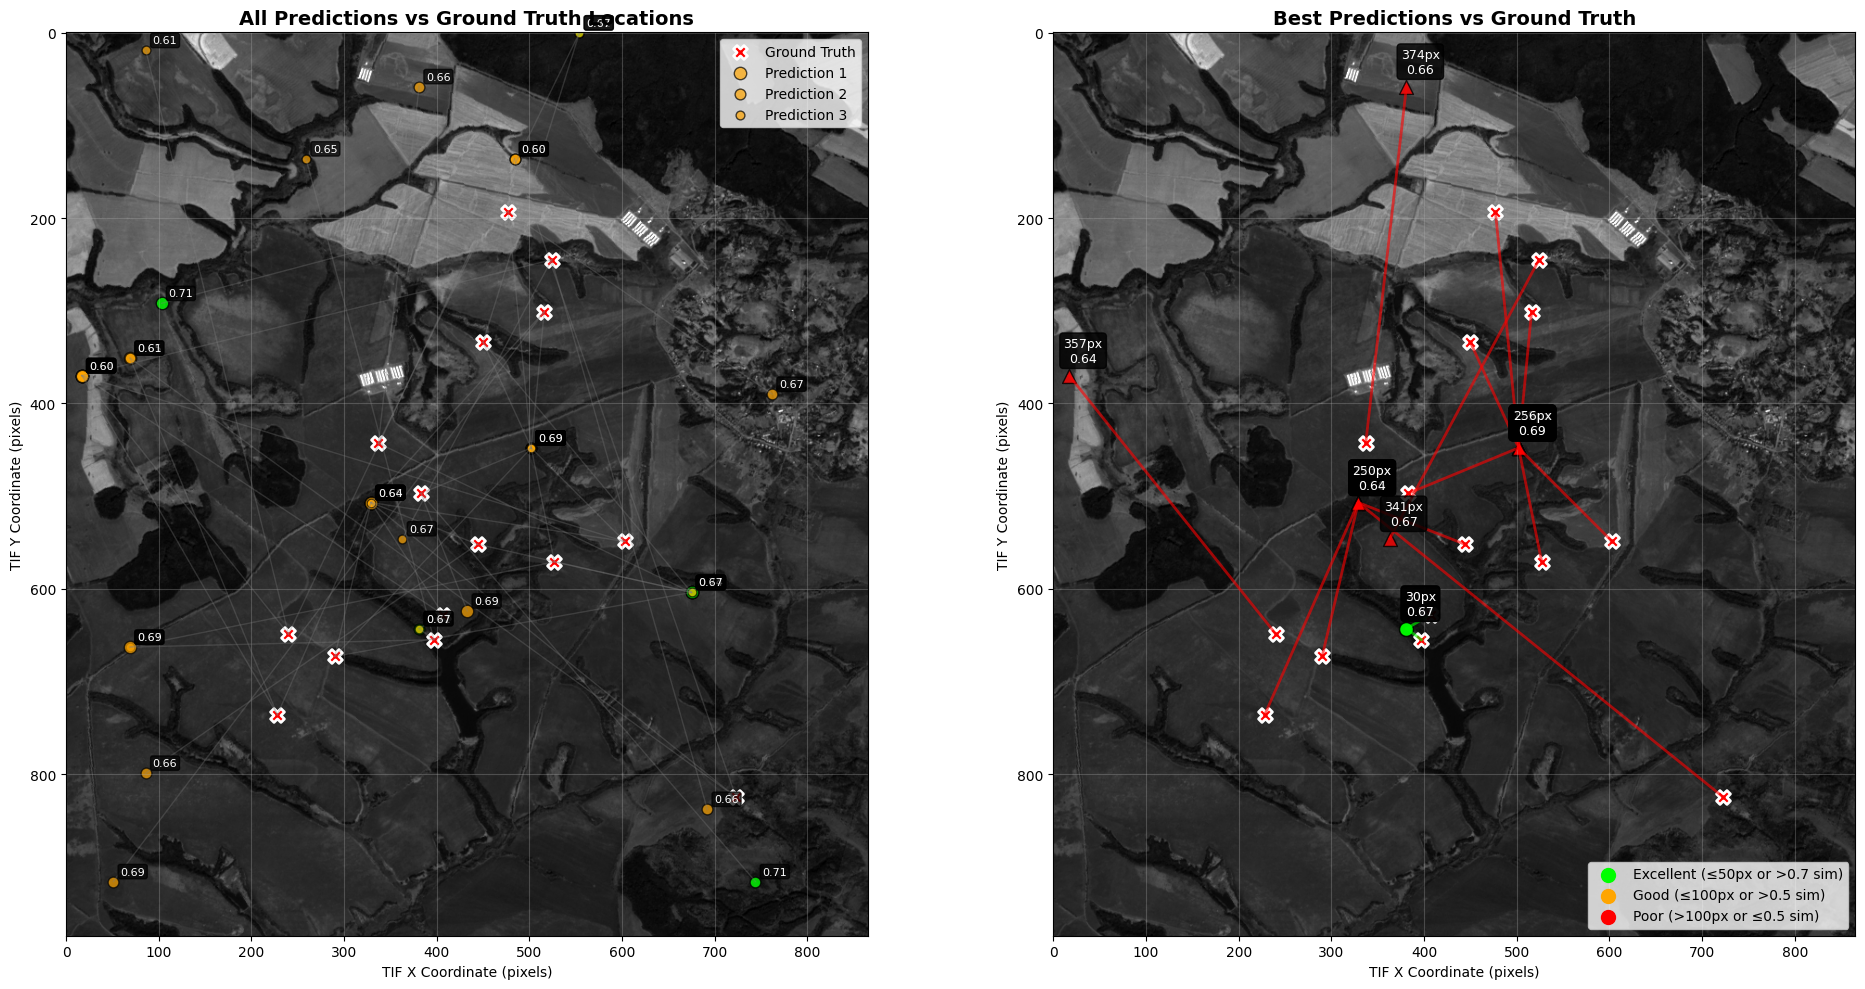

   🔍 Creating detailed spatial analysis...


C:\Users\NIKO9\AppData\Local\Temp\ipykernel_43072\3040865990.py:835: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


   💾 Saved detailed analysis: detailed_spatial_analysis.png


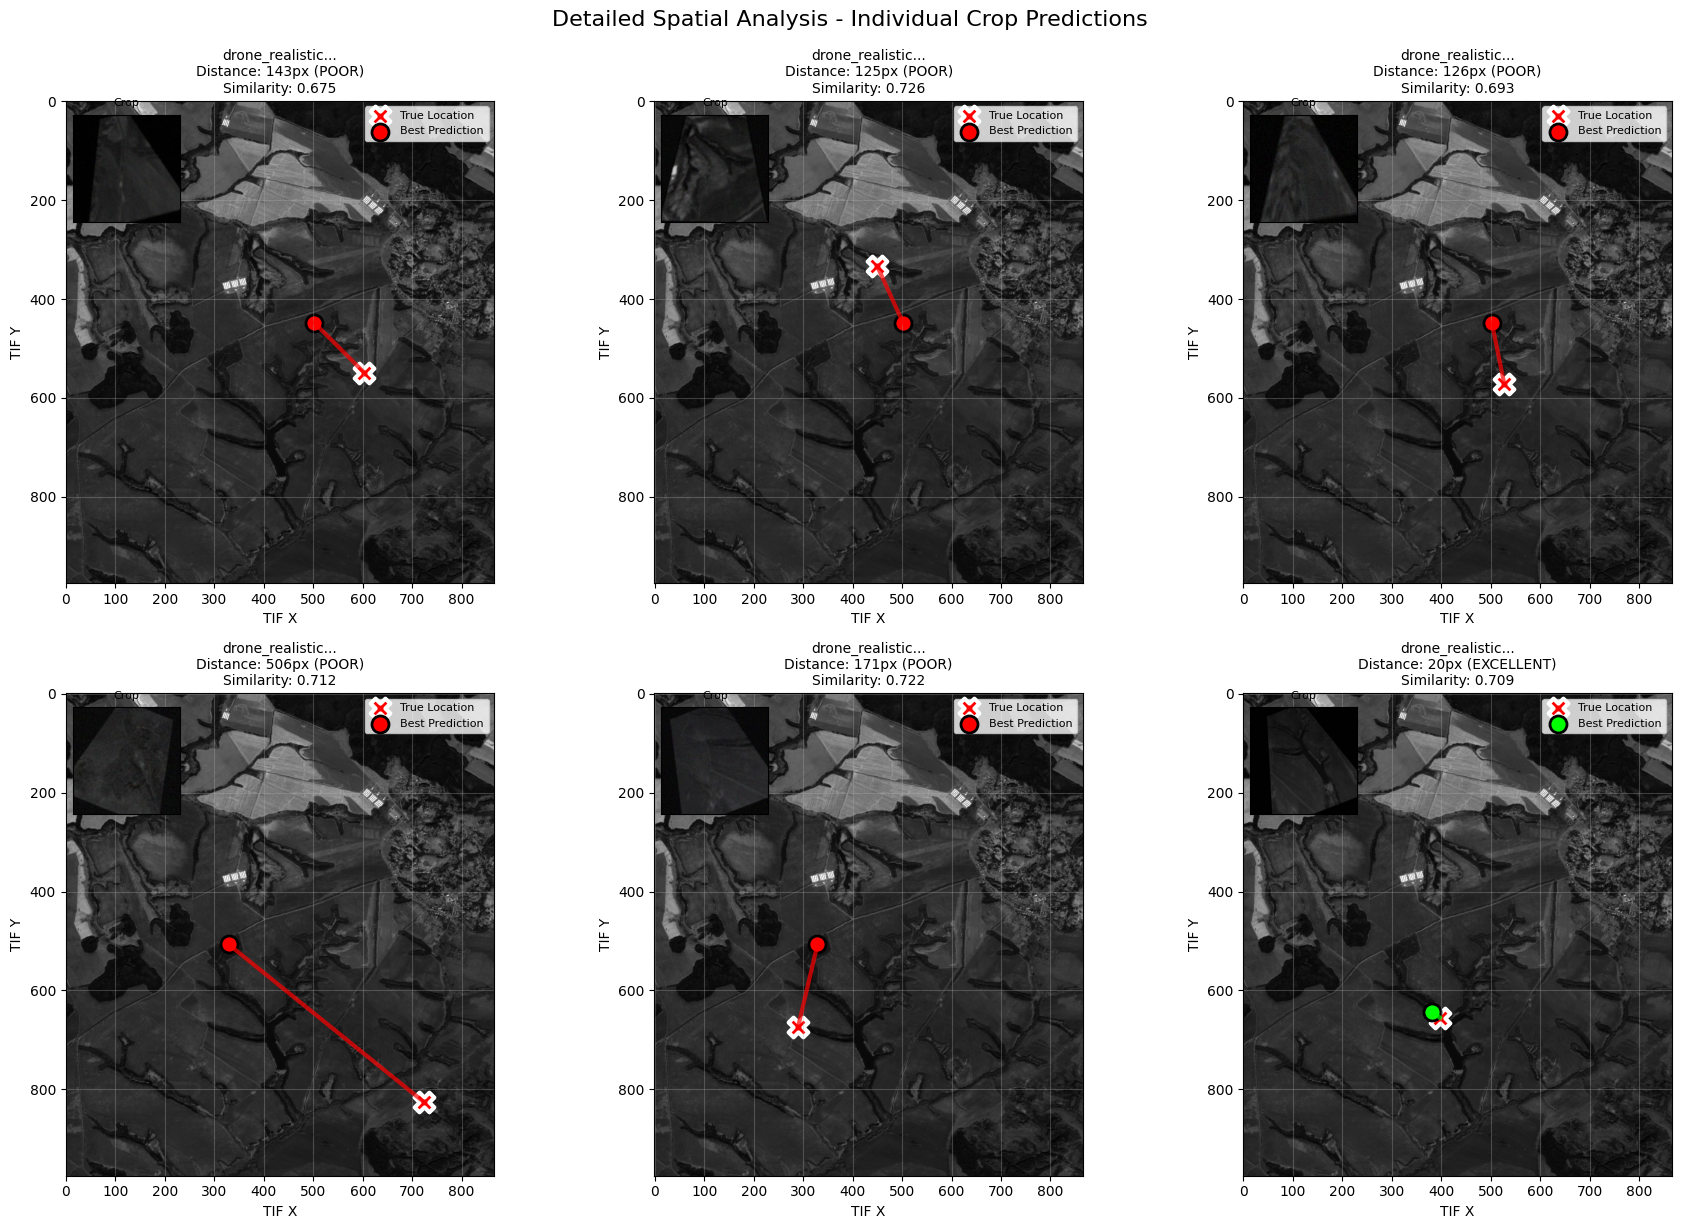


📐 0.5. GRID SYSTEM VISUALIZATION
   📐 Visualizing grid system...
   💾 Saved grid visualization: grid_system_visualization.png


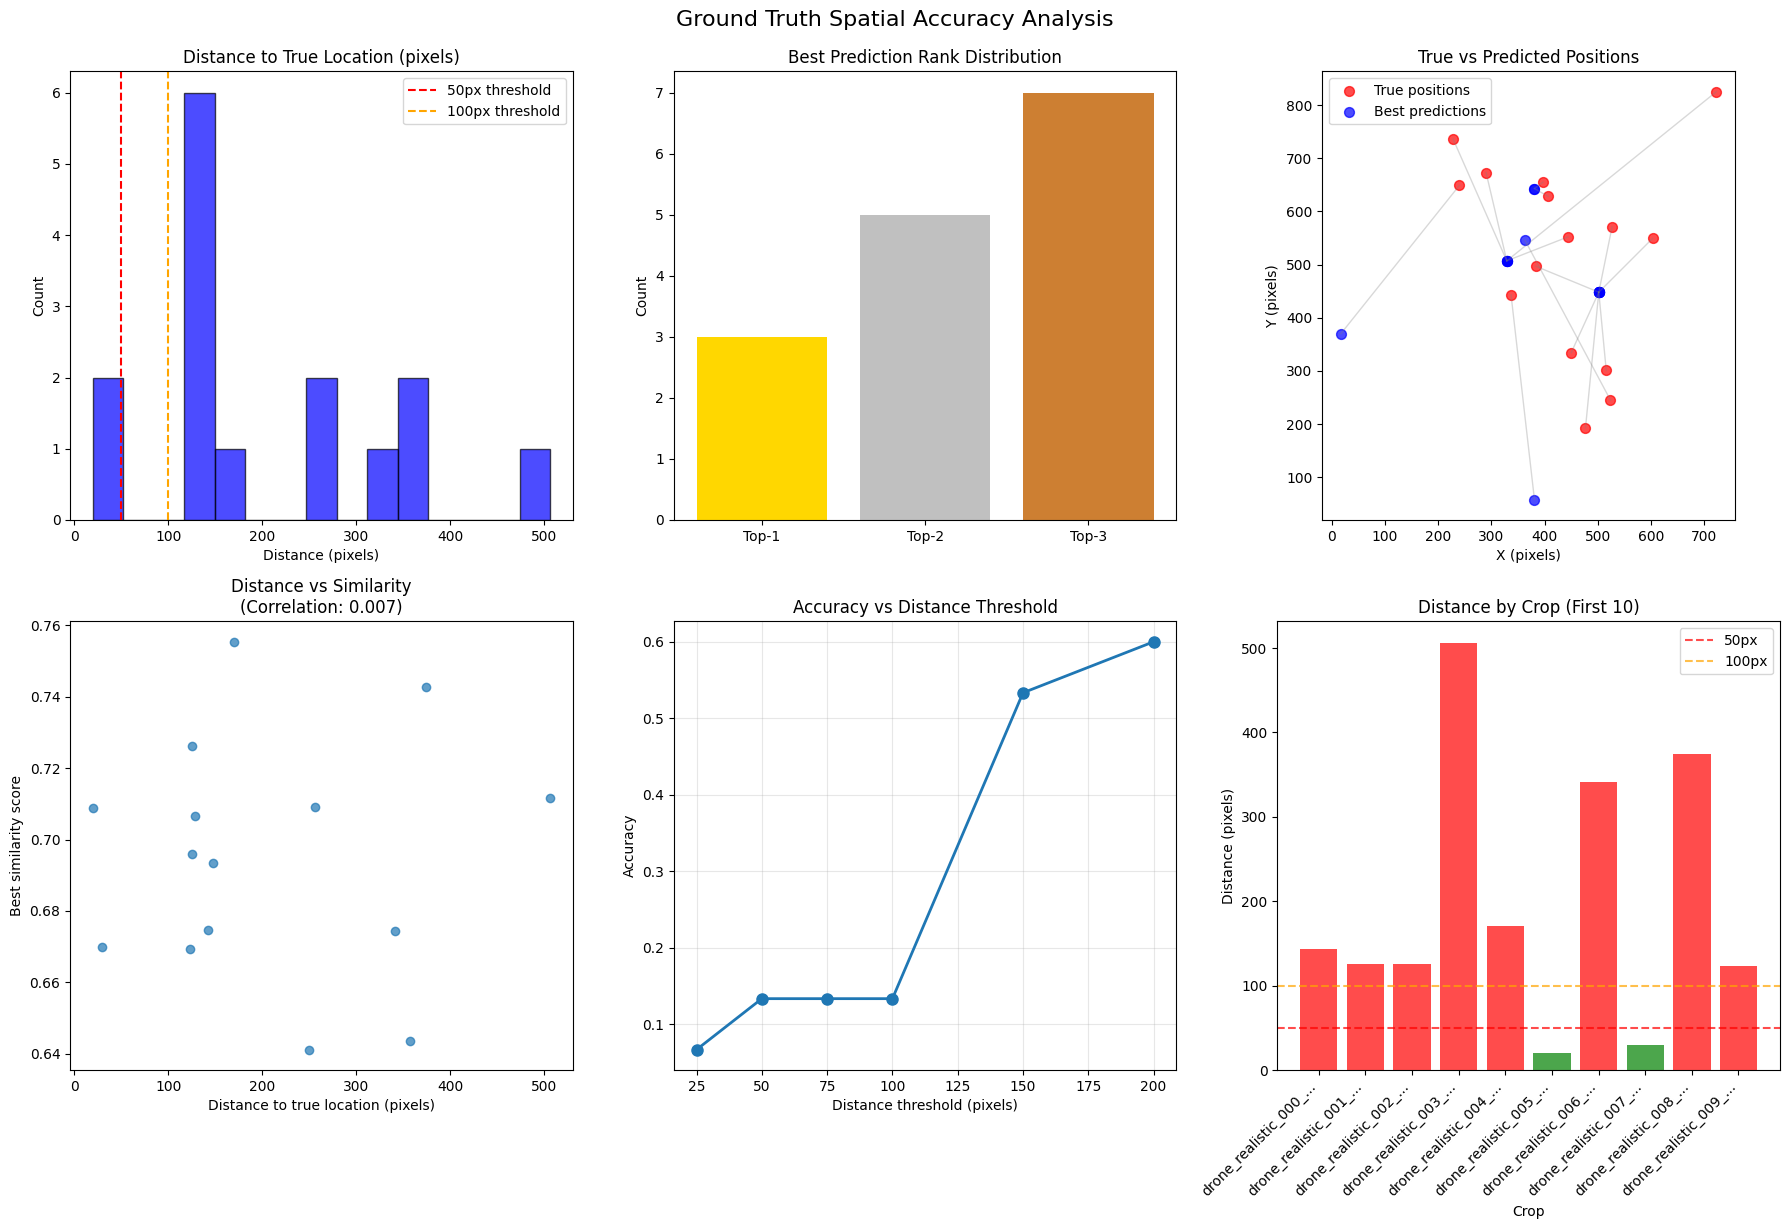

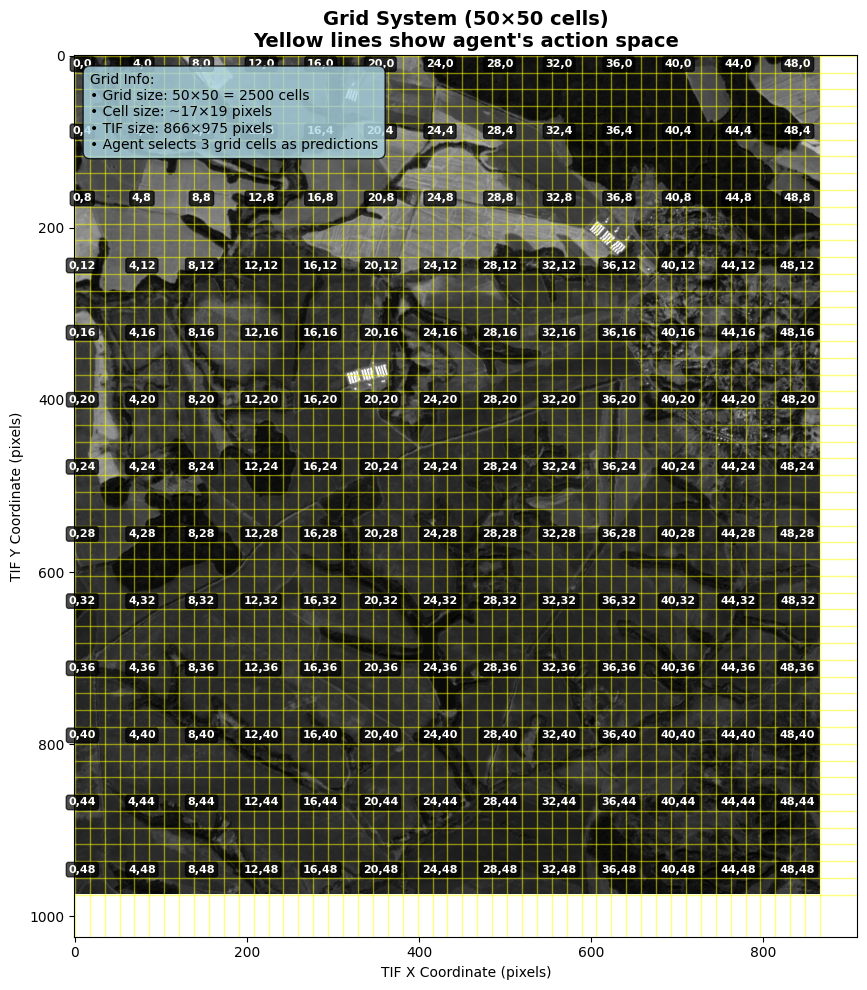


📸 1. VISUAL VALIDATION
   📸 Generating visual validation examples...


c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


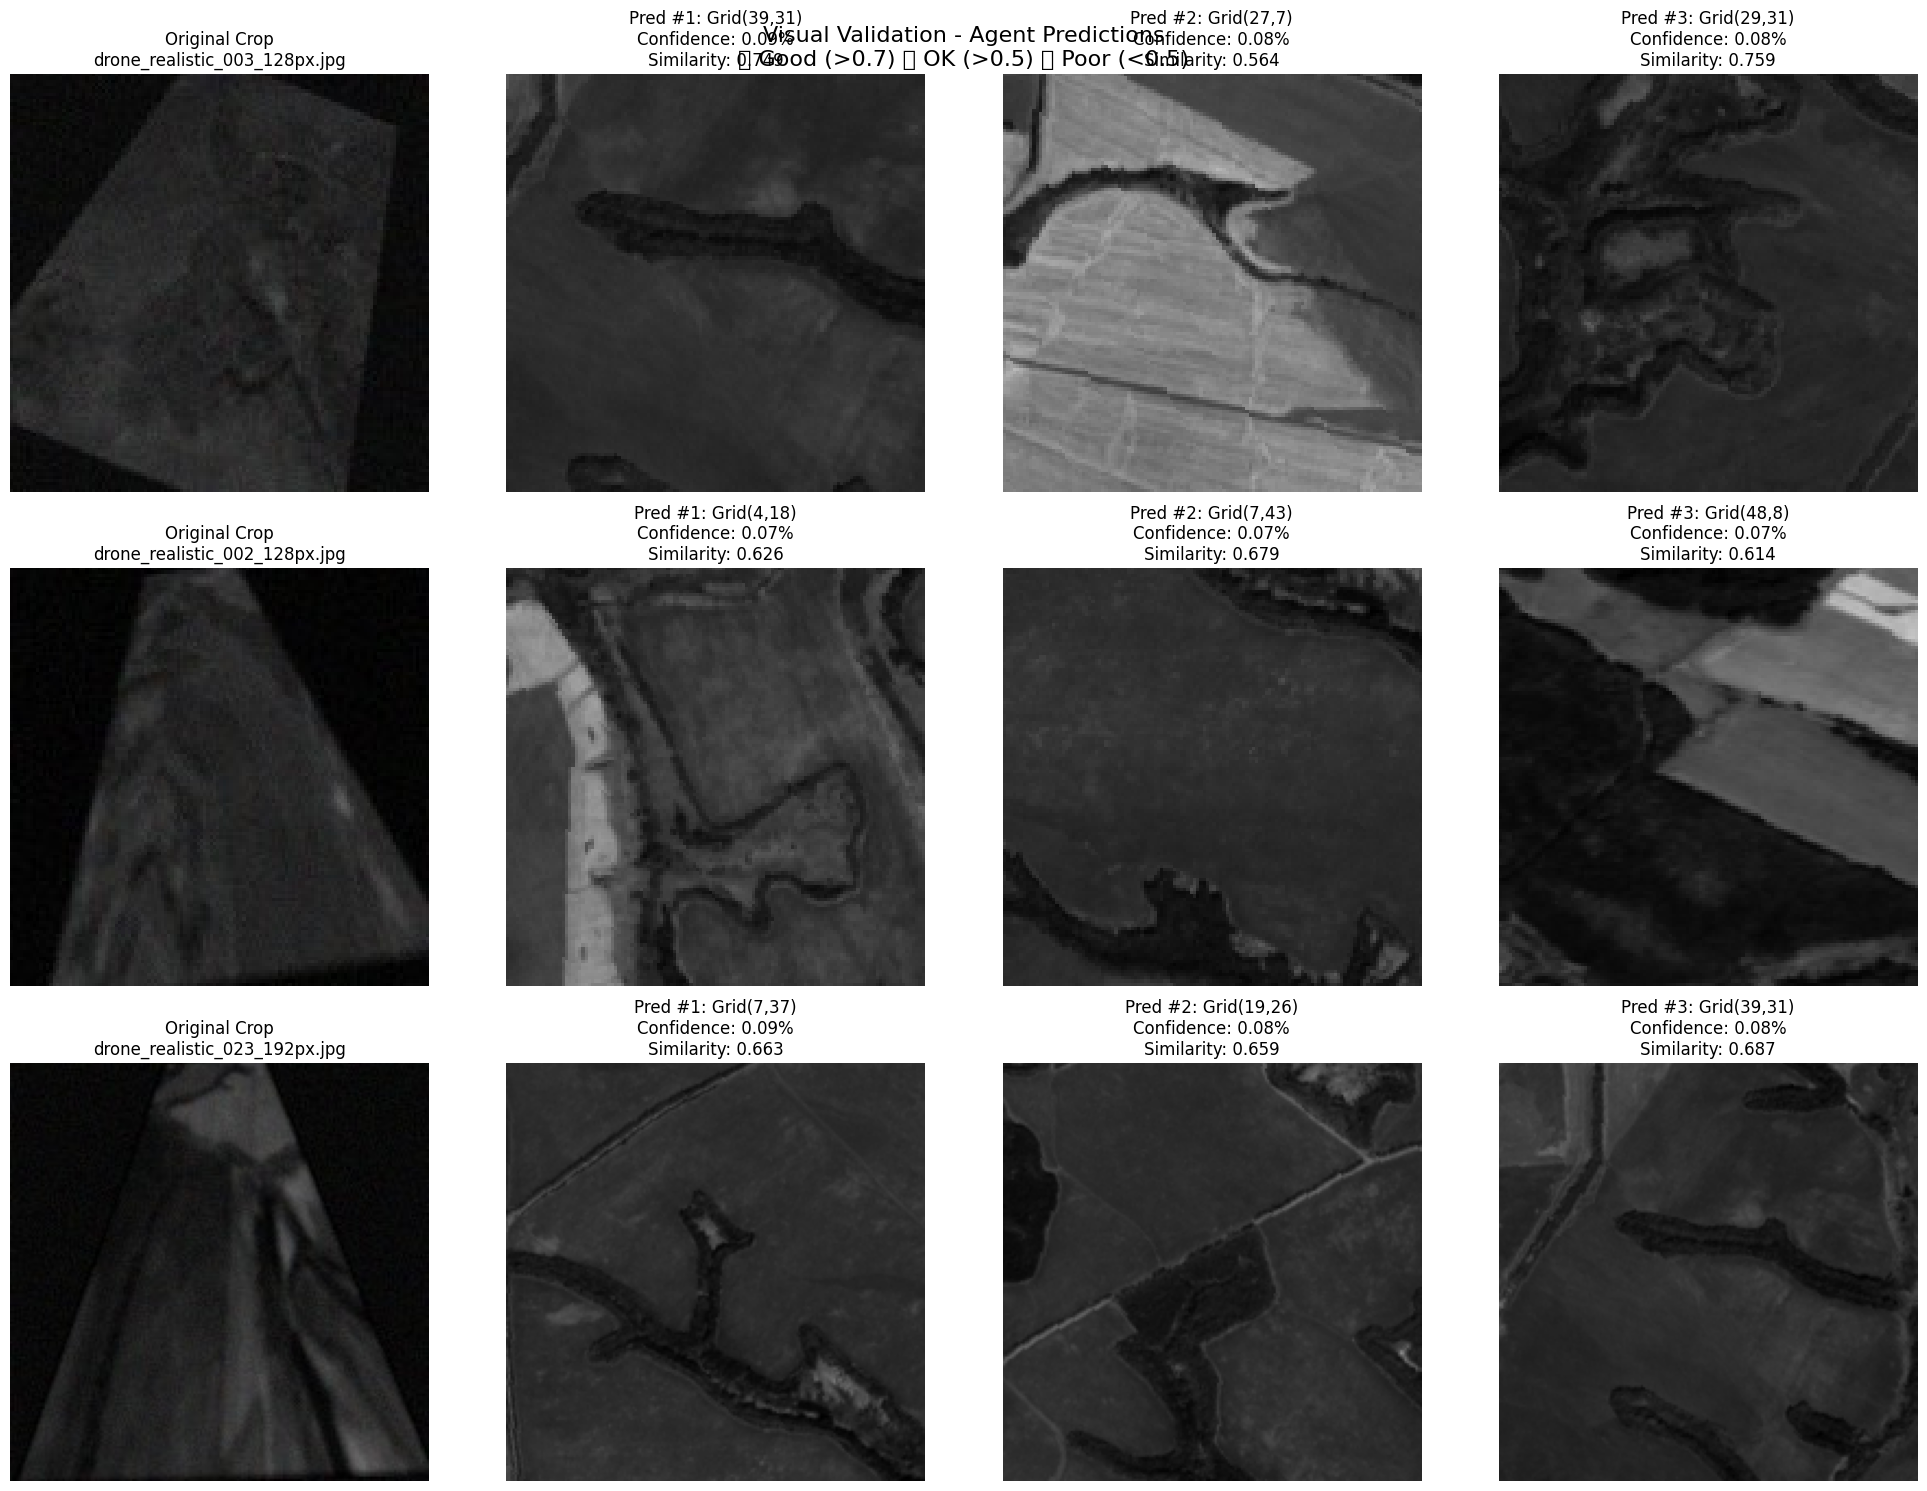

   📊 Visual Validation Results:
      Average similarity: 0.667
      Best similarity: 0.759
      Good predictions (>0.7): 2/9

📊 2. QUANTITATIVE METRICS
   📊 Computing quantitative metrics...
   📈 Quantitative Results:
      Mean Top-1 Similarity: 0.670
      Mean Max Similarity: 0.700
      Top-1 Success Rate (>0.7): 33.3%
      Top-3 Success Rate (>0.7): 40.0%
      Confidence-Accuracy Correlation: 0.045


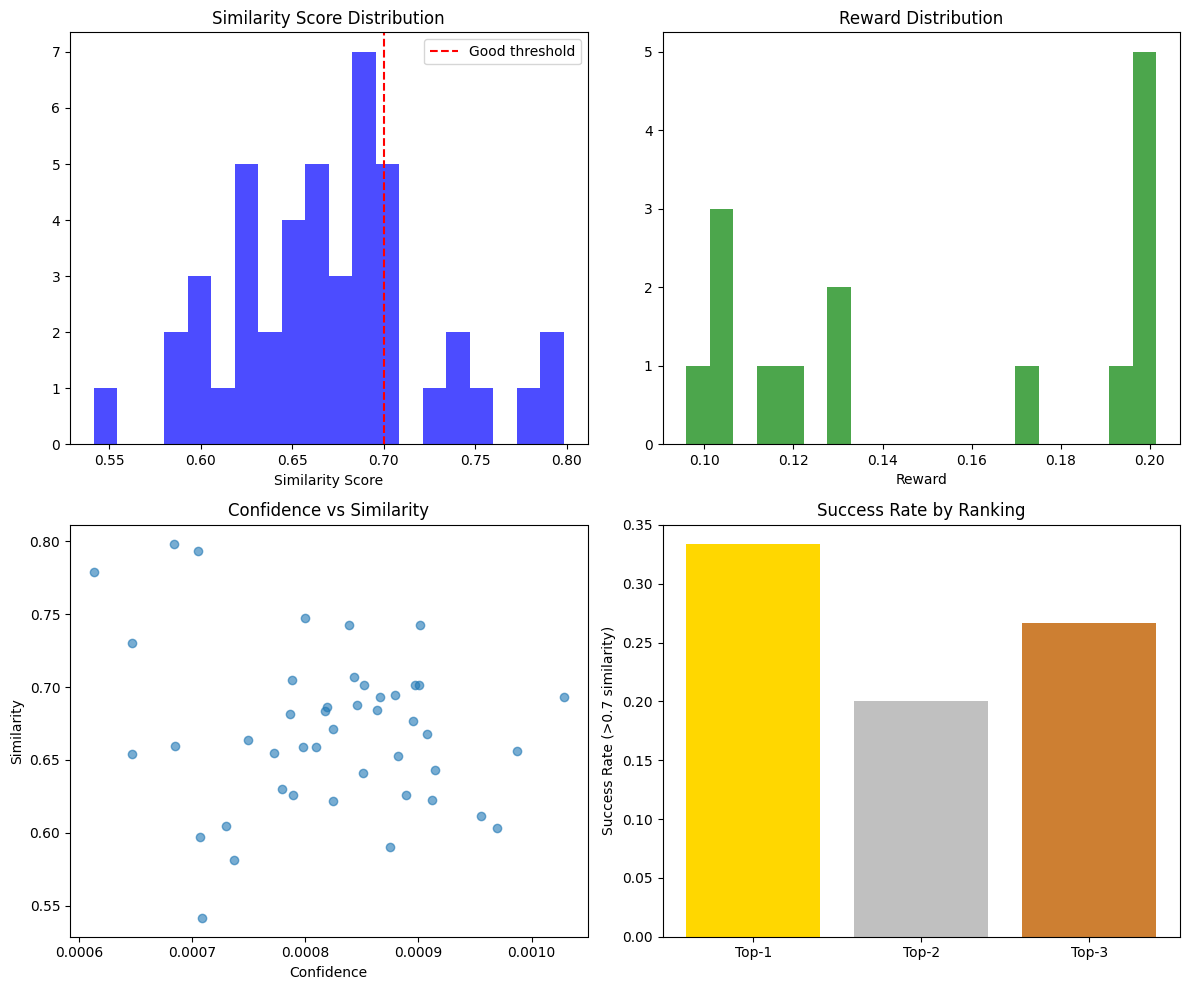


🧪 3. SYNTHETIC TEST CASES
   🧪 Creating synthetic test cases...
   🎯 Synthetic Test Results:
      Identity test success rate: 0.0%
      Mean distance to planted crop: 10.15 grid cells
      Top-1 detection rate: 60.0%

🔄 4. CROSS-VALIDATION
   🔄 Cross-validation by crop characteristics...
      Found 0 altitude groups: []
   📊 Cross-validation Results:

🎯 5. CLUSTERING ANALYSIS
   🎯 Analyzing spatial clustering of predictions...
      Spatial analysis: 10 predictions
      Optimal clusters: 2
      Spread: [12.81561547  8.76127845] (grid units)

🚀 6. TRANSFER CAPABILITY TEST
   🚀 Transfer capability test...
      Note: Requires multiple TIF files for full transfer test
      Current test: Robustness across different regions of same TIF
      Regions tested: 5
      Mean performance: 0.672
      Consistency: 0.975

📋============================================================📋
    VALIDATION REPORT
📋============================================================📋

🎯 SPATIAL ACCURACY (GR

C:\Users\NIKO9\AppData\Local\Temp\ipykernel_43072\3040865990.py:669: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\NIKO9\AppData\Local\Temp\ipykernel_43072\3040865990.py:669: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\NIKO9\AppData\Local\Temp\ipykernel_43072\3040865990.py:669: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\NIKO9\AppData\Local\Temp\ipykernel_43072\3040865990.py:669: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\NIKO9\AppData\Local\Temp\ipykernel_43072\3040865990.py:669: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\NIKO9\AppData\Local\Temp\ipykernel_43072\3040865990.py:669: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from f

   💾 Saved validation summary: validation_summary.png


c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu San

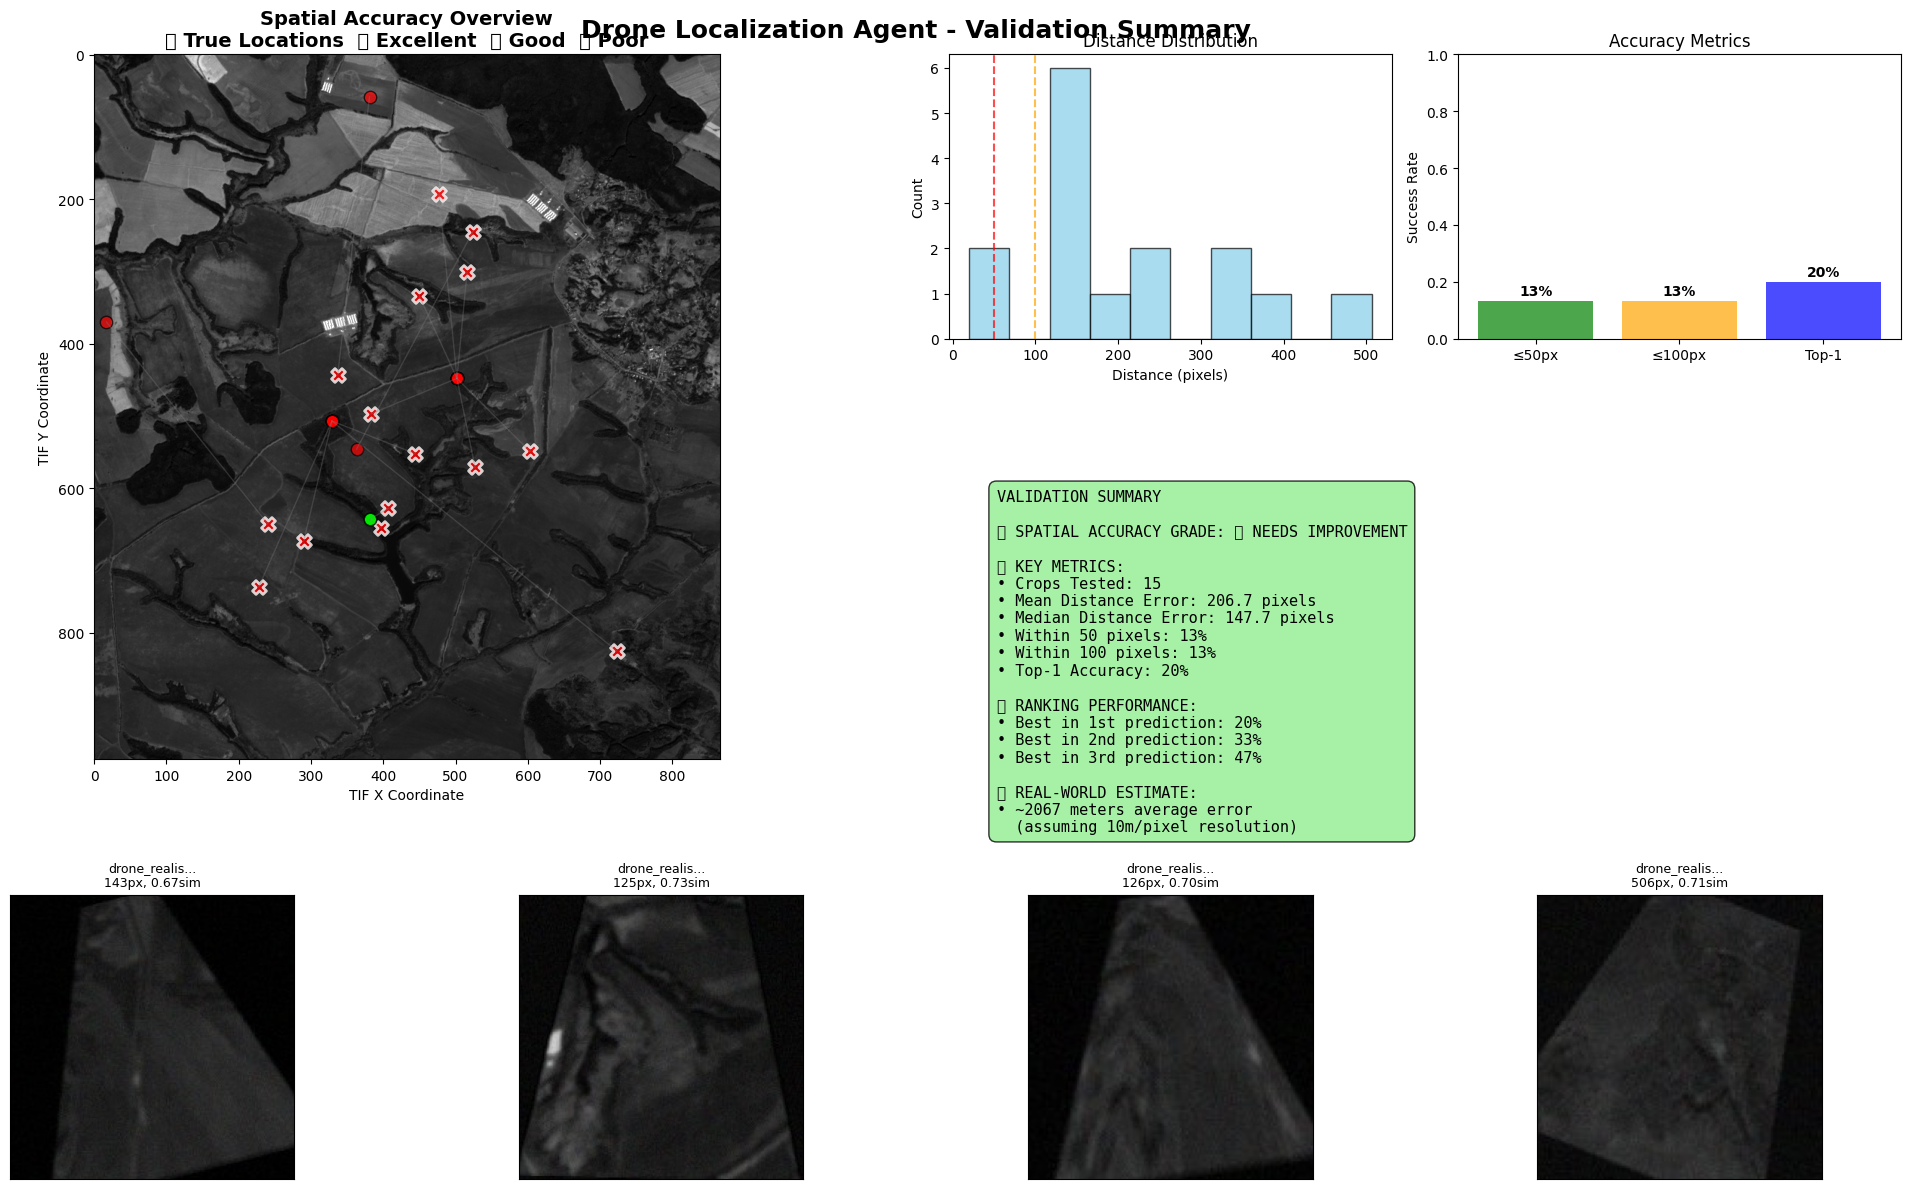

In [4]:
validator, results = validate_drone_agent(trainer)